# <a id='toc1_'></a>[Mini challenge retrieval augmented generation (RAG)](#toc0_)
> Oliver Pejic; Arian Iseni; Christof Weickhardt. 

> This notebook delves into the evaluation of Retrieval-Augmented Generation (RAG) systems, focusing on optimizing information retrieval and answer generation. It investigates various embedding models, chunking strategies, and the innovative Hypothetical Document Embedding (HyDE) approach. The notebook outlines experiments that assess these methodologies against a set of metrics designed to measure aspects like faithfulness, relevancy, and precision. Key sections cover setup, data preprocessing, embedding techniques, baseline comparisons, and detailed evaluations of different system configurations.

- [Description of the task](https://spaces.technik.fhnw.ch/storage/uploads/spaces/81/exercises/20240911_NPR_Trainingscenter_MiniChallenge_RAG-1729000458.pdf)
- [Introduction RAG](https://spaces.technik.fhnw.ch/storage/uploads/spaces/81/Retrieval-Augmented-Generation-Intro-1727189074.pdf)

[**Table of content**](#toc0_)
- [Mini challenge retrieval augmented generation (RAG)](#toc1_)
- [Our approach](#toc2_)
- [Setup](#toc3_)
- [Data Loading & Preprocessing](#toc4_) 
- [Chunking](#toc5_)
- [Embedding & VectorDB](#toc6_)
- [Reasoning for our models](#toc7_)
- [Baseline Pipeline](#toc8_)
- [Evaluation Metrics](#toc9_)
  - [Ragas Metrics](#toc9_1_)
  - [Non-LLM Based Metrics](#toc9_2_)
- [Evaluation and cleaned data](#toc10_)
- [Experiment Embedding models:](#toc11_)
  - [Qwen2 Embedding Model](#toc11_1)
  - [Nomic Embedding Model](#toc11_2)
- [Experiment chunking strategies:](#toc12_)
  - [Recursive Chunking(500/100)](#toc12_1)
  - [Semantic Chunker](#toc12_2)
- [Experiment HyDE:](#toc13_)
- [Personal Takeaways](#toc14_)
- [AI Tools - Improving Our Project with Assistance](#toc15_)
  - [How AI Tools Help Us](#toc15_1_)
  - [Using ChatGPT](#toc15_2_)
  - [Using GitHub Copilot](#toc15_3_)
  - [What Works Best When Asking AI for Help](#toc15_4_)
  - [Summary](#toc15_5_)

# <a id='toc3_'></a>[Setup](#toc0_)
For consistency, we created a `config.py` file which contains all the necessary paths.  
It includes:
- `CACHE_DIR` for caching the datasets and evaluation results
- `PERSISTENT_DIR` for storing the vector database
- `CLEAN_FILE_PATH` for the preprocessed data
- `EVAL_FILE_PATH` for the evaluation data

To share the local embedding models with everyone, we created an account at [Tailscale](https://tailscale.com) and the host shared the machine with the other team members.

# <a id='toc4_'></a>[Data Loading & Preprocessing](#toc0_)

We will now load the data into a pandas DataFrame and preprocess it. This preprocessing is informed by the insights documented in the `notebooks/cleaning.ipynb` notebook.

The preprocessing steps are implemented in the `src/preprocess.py` file. A class named `TextPreprocessor` is responsible for preparing the main dataset for indexing and retrieval. The preprocessing includes the following steps:

The preprocessing includes the following steps:

1.	Language Detection and Filtering: Retain only English texts to ensure language consistency.
2.	HTML Cleaning: Strip out HTML tags to focus on the raw textual data.
3.	Special Character Removal: Remove unwanted non-alphanumeric characters while retaining essential punctuation.
4.	Duplicate Removal: Eliminate duplicate text entries to ensure data uniqueness.
5.	Unique Identifier Generation: Create a unique ID for each dataset row using a hash of its content.

In [1]:
import pandas as pd
import src.utils as utils

df = pd.read_csv(
    "data/raw/cleantech_media_dataset_v2_2024-02-23.csv"
)
df.head()

,Unnamed: 0,title,date,author,content,domain,url
0,1280,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,1281,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,1283,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,1284,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,1285,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


In [2]:
# delete author col
df = df.drop(columns=['author'])
# rename Unnamed: 0 to 'id'
df = df.rename(columns={'Unnamed: 0': 'id'})

In [3]:
from src.preprocess import TextPreprocessor

tp = TextPreprocessor(df, 'content')

cleaned_data = tp.preprocess_data()

tp.add_unique_id()

100%|██████████| 9588/9588 [00:02<00:00, 4168.81it/s]


,id,title,date,content,domain,url
0,92151dc1d9bfd38bf55079fd769ba2bb,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,Qatar Petroleum QP is targeting aggressive cut...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,9f0a279c373edf56b634cf6dd1e38698,India Launches Its First 700 MW PHWR,2021-01-15,Nuclear Power Corp. of India Ltd. NPCIL synchr...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,7c349533119a90fa56515421e69c0e45,New Chapter for US-China Energy Trade,2021-01-20,New US President Joe Biden took office this we...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,5acd9a610210fdf0afd261c35b1fe287,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,The slow pace of Japanese reactor restarts con...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,2159fa0bb2c86e538844a6307bb9b677,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,Two of New York City s largest pension funds s...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
...,...,...,...,...,...,...
9588,237dbe84d31e0913fa60adad838f6ed5,Strata Clean Energy Nets $ 300 Million in Fund...,2023-11-06,Strata Clean Energy has closed a 300 million r...,solarindustrymag,https://solarindustrymag.com/strata-clean-ener...
9589,dfbc6cbe8872d1655d0b28d671a94260,Orsted Deploying SparkCognition Renewable Suit...,2023-11-07,Global renewable energy developer rsted is dep...,solarindustrymag,https://solarindustrymag.com/orsted-deploying-...
9590,36f89d36130ca74503d7e841a6a17d93,Veolia Has Plans for 5 MW of Solar in Arkansas,2023-11-07,"Veolia North America, a provider of environmen...",solarindustrymag,https://solarindustrymag.com/veolia-has-plans-...
9591,54101834542d8b996a1c3533eed67176,"SunEdison: Too Big, Too Fast?",2023-11-08,Once the self proclaimed leading renewable pow...,solarindustrymag,http://www.solarindustrymag.com/online/issues/...


The preprocessed data is then saved to a new CSV file for further analysis.

In [4]:
from src.config import CLEAN_FILE_PATH

cleaned_data.to_parquet(CLEAN_FILE_PATH)

# <a id='toc5_'></a>[Chunking](#toc0_)
Text chunking involves dividing large documents into smaller, manageable pieces or “chunks” that are easier to process and index. This is particularly useful when dealing with extensive datasets or documents, where processing the entire content at once would be computationally expensive and inefficient.

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

recursive_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False,
)

documents = utils.create_documents(df, recursive_text_splitter)

RecursiveCharacterTextSplitter: Documents created: 51854, Rows: 9593, Percentage of doc created: 540.54%


This part splits the DataFrame containing large texts into smaller, non-overlapping chunks for easier processing. Each chunk is up to 1000 characters long. The RecursiveCharacterTextSplitter is initialized with no overlap to ensure each character in the original text is unique to one chunk, preventing redundancy and maintaining clear separation between chunks. The function checks for necessary metadata columns, handles missing values, and uses these metadata along with the text content to generate smaller document chunks. It provides feedback on the number of documents created compared to the original DataFrame size.

## <a id='toc6_'></a>[Embedding & VectorDB](#toc0_)
In a RAG system, both embeddings and a vector database play crucial roles in the process of augmenting language generation with retrieval capabilities. Embeddings and vector databases in RAG systems bridge the gap between raw user queries and informative content in vast document collections, enhancing the generation of responses by making them more relevant and contextually aware. 

Since we already set up the every vector database in `chunking_embed_vectorstore.ipynb`, we just will call them here and use it for the next steps. 

In [14]:
from src.vectorstorage import EmbeddingVectorStorage
from src.custom_embeddings import bge_m3_embed
from src.config import PERSISTENT_DIR

collection_name = "BAAI_bge_m3_RecursiveCharacterTextSplitter" 

bge_m3_vectordb_baseline = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection=collection_name,
    path_persistent=str(PERSISTENT_DIR),
)

And with the `.test_heartbeat()` and `.collection_is_empty()` we will check if the collection exists and is not empty.

In [15]:
print(f"Heartbeat: {bge_m3_vectordb_baseline.test_heartbeat()}\n Collection is empty: {bge_m3_vectordb_baseline.collection_is_empty()}")

Heartbeat: 1732249537037226000
 Collection is empty: False


What happens in the `chunking_embed_vectorstore.ipynb`: We first initialize and utilizes [HuggingFaceEndpointEmbeddings](https://python.langchain.com/docs/integrations/text_embedding/text_embeddings_inference/) along with a [ChromaDb](https://www.trychroma.com) vectorstore system to handle and query large sets of document embeddings efficiently. The custom embedding models are defined in the `CustomHuggingFaceEndpointEmbeddings` class, which extends the capabilities of HuggingFace's endpoint embeddings to include a `model_name` attribute. This addition helps identify and manage multiple models within our system.

Each model is configured with a specific server endpoint URL and is responsible for transforming text into embeddings. These embeddings are then stored and managed in a `chromadb` based vector storage system, which allows for efficient retrieval and management of the vector data.

The script performs the following key operations:
1. Initializes three embedding models with unique names and endpoints.
2. Embeds a sample query using each model and prints the first 20 elements of the embeddings for verification.
3. Defines a function to generate unique collection names for storing embeddings based on the model's name and the text splitter class, ensuring organized data management.
4. Creates a vector storage instance for each model and includes the processed documents into the database, with progress updates provided if verbose is enabled.
5. Demonstrates querying the vector storage with a sample text to find and print documents similar to the query along with their similarity scores.
6. Includes error handling to manage and report potential issues during the search operations, ensuring the robustness of the system.

### <a id='toc7_'></a>[Reasoning for our models](#toc0_)

1. **`bge_m3_embed` (BAAI_bge_m3)**  
   **Reasoning:** This model is designed for general-purpose embeddings, excelling in capturing semantic relationships for multilingual datasets. It is ideal for scenarios requiring fine-grained semantic search or multilingual support.  
   **Pros:** Multilingual support, robust semantic understanding.  
   **Cons:** May require significant computational resources, potentially slower on large datasets.  

2. **`qwen2_embed` (Alibaba-NLP_gte-Qwen2-7B)**  
   **Reasoning:** Qwen-2-7B provides high-quality embeddings for advanced NLP tasks, leveraging Alibaba's state-of-the-art transformer architecture to excel in contextual understanding. It is suited for complex text understanding and higher-dimensional embeddings.  
   **Pros:** High performance in contextual embeddings, ideal for specialized use cases.  
   **Cons:** Larger model size may result in increased latency and higher memory requirements.  

3. **`nomic_embed` (nomic-ai_nomic-embed-text-v1_5)**  
   **Reasoning:** The Nomic embedding model specializes in clustering and visualization tasks, making it valuable for exploratory data analysis and text clustering projects.  
   **Pros:** Optimized for clustering and visualization, efficient for exploratory workflows.  
   **Cons:** Less general-purpose compared to other models and limited in handling domain-specific tasks outside its design focus.

### <a id='toc8_'></a>[Baseline Pipeline](#toc0_)
Our baseline pipeline for question answering employs a multi-component approach integrating embeddings, language models, and various utilities from the LangChain library. This setup allows for efficient retrieval and processing of relevant documents to generate accurate answers to user queries.

**Components**

1.	Embeddings:
- We utilize the bge_m3_vectordb from the LangChain library, which is backed by embeddings from Hugging Face. These embeddings are crucial for retrieving the most relevant documents from our database based on the semantic similarity to the input query.
2.	Language Models:
- The core of our language processing is handled by the OllamaLLM from the LangChain’s Ollama module, specifically using the qwen2.5:0.5b-instruct-q4_0 model. This model is designed to understand and generate human-like text based on the context provided by the retrieved documents.
3.	Retrieval and Processing Utilities:
- Retriever: The basic retriever setup uses the as_retriever() method from bge_m3_vectordb, which efficiently identifies and fetches documents relevant to the input question.
- [**Prompt**](https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=2d6cd9b7-5b49-44db-a523-a13c23f12f29): We leverage a pre-built prompt from LangChain’s hub, specifically rlm/rag-prompt. This prompt is tailored to guide the model in generating coherent and contextually appropriate responses.

In [17]:
from langchain_ollama import OllamaLLM
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

# Load Api Keys
load_dotenv()

# Load the VectorDB baseline retriever
basic_retriever = bge_m3_vectordb_baseline.as_retriever()

# Load local Qwen2.5 3B model
qwen2_5_3B = 'qwen2.5:3b-instruct'

llm_model = OllamaLLM(model=qwen2_5_3B)

# Load OpenAI model
openai_llm_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

[**Pipeline Execution**](https://python.langchain.com/v0.1/docs/use_cases/question_answering/sources/)

The execution of the pipeline is initialized by invoking the basic_rag_chain with a sample question. The process includes:

- Retrieving contextually relevant documents using the embedded database.
- Formatting the retrieved documents into a structured format that is then processed by the rag_chain_from_docs sequence.
- Generating an answer through the orchestrated interaction of the retriever, prompt, and language model.

In [18]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel


basic_prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | basic_prompt
    | llm_model
    | StrOutputParser()
)

basic_rag_chain = RunnableParallel(
    {"context": basic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

For the chain we got inspired by the [LangChain documentation](https://python.langchain.com/v0.1/docs/use_cases/question_answering/sources/). The `basic_rag_chain` is a sequence of runnables that orchestrates the retrieval, processing, and generation of answers to user queries. It leverages the LangChain library to streamline the interaction between the retriever, prompt, and language model, ensuring a coherent and contextually relevant response to the input question.
The prompt is called from Langchain Hub and is detailed [here](https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=2d6cd9b7-5b49-44db-a523-a13c23f12f29).
The `basic_rag_chain` can now generate answers for questions. Here you can see a test with a question to see how it works.

In [19]:
basic_rag_chain.invoke("Is Mississipi an anti-ESG state?")

{'context': [Document(metadata={'date': '2023-05-15', 'domain': 'cleantechnica', 'origin_doc_id': '6b8fb712bcb9febe268e3679851e725e', 'title': 'ESG, Much? Mississippi Takes Green Hydrogen To The Next Level', 'url': 'https://cleantechnica.com/2023/05/15/mississippi-takes-green-hydrogen-to-next-level/#zox-comments-button'}, page_content='State office holders in Mississippi continue to spout anti ESG rhetoric, but a massive green hydrogen hub is taking shape right under their feet. , The Energy Department launched an 8 billion hydrogen program last year, and state officials around the nation are scrambling to get a slice of the pie. In some cases they are even putting partisan politics aside. The latest example is the deep red state of Mississippi, where the firm Hy Stor Energy is working on a plan to transform the Magnolia State into a green hydrogen powerhouse. , Mississippi is among two dozen or so states in which Republican governors, legislators, treasurers, and attorneys general hav

# <a id='toc9_'></a>[Evaluation Metrics](#toc0_)

To properly assess and compare different computational systems, we use a structured evaluation approach. This includes using the `ragas` library for language model-based metrics and traditional metrics for other types of systems. Below, we explain the specific metrics we use in our evaluations, designed to accurately gauge various aspects of system performance.

## <a id='toc9_1_'></a>[Ragas Metrics](#toc0_)

We use the following metrics from the ragas library to evaluate the quality of answers and how relevant the contexts are that language model-based systems provide:

1.	[**Faithfulness**](https://docs.ragas.io/en/v0.1.21/concepts/metrics/faithfulness.html): Measures the factual consistency of the generated answer against the given context. It is computed by identifying claims in the answer and verifying if each can be inferred from the context. The metric ranges from 0 to 1, where higher scores indicate better factual consistency.

2.	[**Answer Relevancy**](https://docs.ragas.io/en/v0.1.21/concepts/metrics/answer_relevance.html): Assesses the pertinence of the generated answer to the given prompt. It is calculated by comparing the mean cosine similarity of the original question to artificially generated questions based on the answer. High scores are given to answers that address the prompt directly and appropriately, without redundant details or omissions.

3.	[**Context Precision**](https://docs.ragas.io/en/v0.1.21/concepts/metrics/context_precision.html): Evaluates the accuracy with which relevant items from the context are retrieved and ranked. This metric checks if the essential chunks of context appear at the top of the ranking, using a range from 0 to 1 where higher values indicate better precision.

4.	[**Context Entity Recall**](https://docs.ragas.io/en/v0.1.21/concepts/metrics/context_entities_recall.html): Measures the recall of entities from the retrieved context compared to the entities present in the ground truth. This metric is crucial for use cases where specific entity-related information is necessary, such as historical QA or tourism help desks, indicating the fraction of correctly recalled entities.

5.	[**Answer Similarity**](https://docs.ragas.io/en/v0.1.21/concepts/metrics/semantic_similarity.html): Assesses the semantic resemblance between the generated answer and the ideal answer (ground truth). This metric uses a cross-encoder model to calculate semantic similarity, with values ranging from 0 to 1, where higher scores denote a closer alignment with the ground truth.

6.	[**Answer Correctness**](https://docs.ragas.io/en/v0.1.21/concepts/metrics/answer_correctness.html): Evaluates both the semantic and factual accuracy of the generated answer in relation to the ground truth. The metric combines aspects of semantic and factual similarity using a weighted scheme and offers a scoring range from 0 to 1. Higher scores indicate better alignment and correctness, with an optional ‘threshold’ for rounding scores to binary values if needed.

## <a id='toc9_2_'></a>[Non-LLM Based Metrics](#toc0_)

To assess traditional retrieval systems, we use the following non-LLM based metrics, which are essential for evaluating how well these systems perform and how relevant their results are:

1.	**Mean Reciprocal Rank (MRR)**: A ranking quality metric that evaluates how quickly a system can present the first relevant item among its results. MRR is calculated as the average of the reciprocal ranks of the first relevant answer for different queries, where the reciprocal rank is the inverse of the rank at which the first relevant item appears. MRR values range from 0 to 1, with higher values indicating that the first relevant item typically appears earlier in the list, thus suggesting better performance.

2.	**Precision at K**: Measures the accuracy of the system in identifying relevant items within the top K results. Precision at K is the proportion of relevant items among the top K positions in the list, highlighting the system’s effectiveness at ranking relevant documents higher. This metric helps to understand how many of the top K items are actually relevant to the user, with values ranging from 0 to 1 where higher values indicate better accuracy.

3.	**Recall at K**: Evaluates how comprehensive the system’s retrieval is by measuring the proportion of relevant items that are retrieved within the top K results out of all relevant items available in the dataset. This metric assesses the system’s ability to include as many relevant items as possible within the top ranks, reflecting its effectiveness in covering the relevant documents needed for user queries. Similar to Precision, Recall values range from 0 to 1, with higher values indicating more comprehensive retrieval of relevant items.

## <a id='toc10'></a>[Evaluation and cleaned data](#toc0_)

In this section, we assess the performance of our baseline RAG system using both RAGAS and non-LLM metrics. The evaluation aims to establish a robust benchmark for the system’s ability to retrieve and generate answers that are both relevant and accurate.

In [23]:
from src.config import CLEAN_FILE_PATH, EVAL_FILE_PATH
from src.evaluation import RAGEvaluation

clean_file_path = str(CLEAN_FILE_PATH)
eval_file_path = str(EVAL_FILE_PATH)

baseline_evaluation = RAGEvaluation(
    name="Baseline",
    rag_chain=basic_rag_chain,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=bge_m3_embed
)

result_baseline = baseline_evaluation.evaluate(clean_file_path, eval_file_path, bge_m3_vectordb_baseline)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Baseline_qwen2.5:3b-instruct_BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


The `RAGEvaluation` class is designed to evaluate a Retrieval-Augmented Generation (RAG) system by leveraging both RAGAS and non-LLM metrics. It handles data preprocessing, dataset preparation, and the execution of evaluations using configured language models and embeddings. The class also offers functionality to visualize results through various plotting methods, aiding in the comparative analysis of different system configurations or models. This comprehensive evaluation tool streamlines the process of assessing the performance of RAG systems, focusing on metrics such as faithfulness, relevancy, precision, and recall across both generated answers and retrieved contexts.

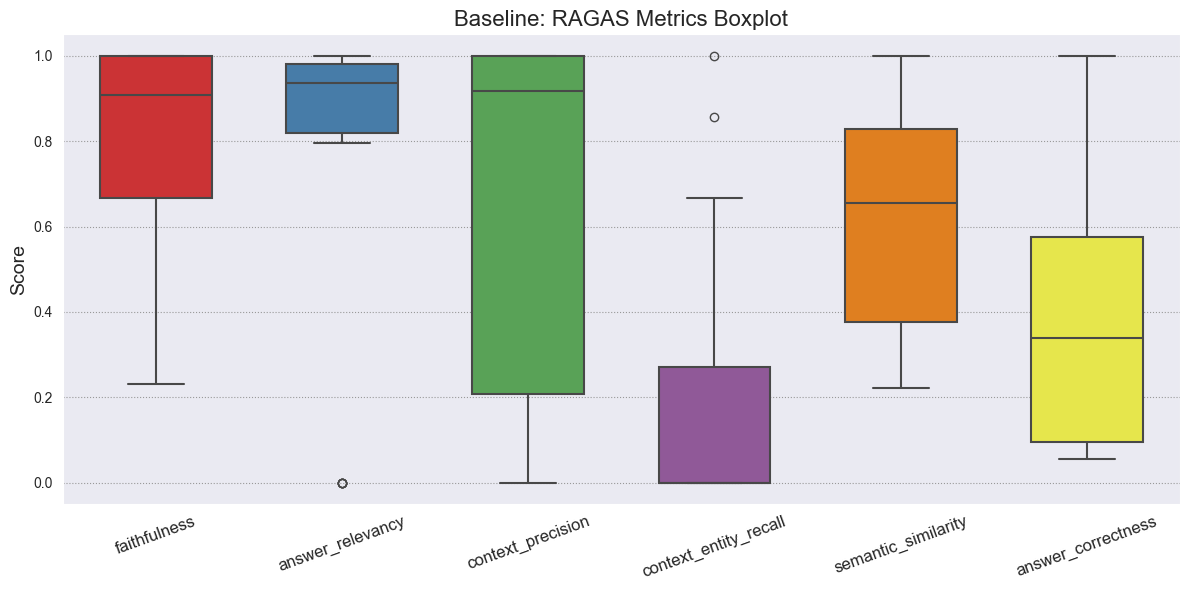

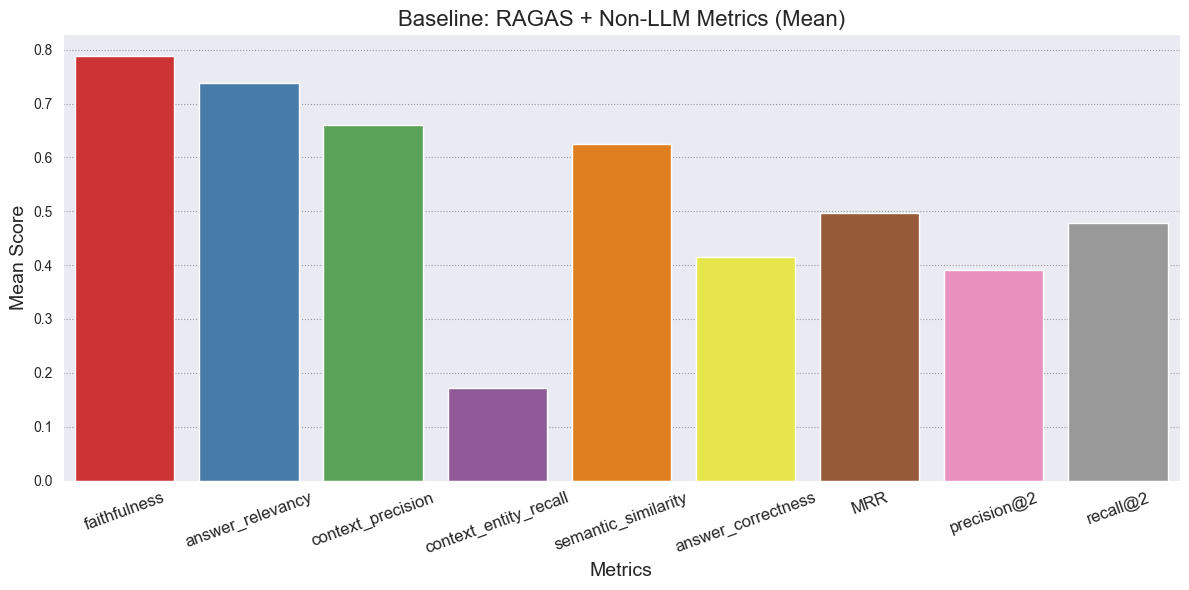

In [21]:
baseline_evaluation.plot_results_all(result_baseline)

**Insights from the Boxplot**

- Faithfulness: This metric shows a fairly consistent high score, with most results clustering near the maximum (1.0), indicating that the system generally produces answers that are factually consistent with the provided contexts.

- Answer Relevancy: Compared to faithfulness, answer relevancy has a lower median and a wider interquartile range, suggesting that while some answers are highly relevant, others may not align as closely with the context.

- Context Precision: The metric scores very highly, showing little variation which indicates that the system effectively retrieves relevant pieces of information from the context.

- Context Entity Recall: This metric displays a significant variance and lower median scores, suggesting difficulties in consistently recalling all relevant entities from the context.

- Semantic Similarity: The distribution shows moderate scores but with considerable spread, indicating variability in how semantically similar the answers are to the ideal responses.

- Answer Correctness: Also shows a wide spread similar to semantic similarity, suggesting that the accuracy of the answers in terms of both factuality and relevancy varies.

**Insights from the Bar Chart**

- The mean scores for all RAGAS metrics are displayed:
    - Faithfulness and Context Precision score very high on average, confirming their strong performance.
    - Context Entity Recall and Semantic Similarity score lower, highlighting areas where the model might be improved.
- Non-LLM Metrics:
    - MRR (Mean Reciprocal Rank) and Recall@2 are displayed with moderate mean values, indicating reasonable but not optimal performance in retrieving the first relevant result and recalling relevant answers within the top two results.
    - Precision@2 has a relatively higher mean score, suggesting that when the system retrieves relevant answers, they are usually within the top two results returned.

**Overall**

- The system demonstrates robustness in maintaining factual consistency and precision in context retrieval but shows potential for improvement in recall of relevant entities and semantic alignment with ideal answers.
- The moderate scores in MRR and recall metrics suggest the need for refining the retrieval mechanisms to ensure that relevant information is prioritized and surfaced effectively.

In [22]:
import src.utils as utils

# Add results to combined df for later comparison
combined_df = utils.add_to_combined("Baseline", result_baseline)

Here, we save the evaluation results from the baseline model into a combined DataFrame for future comparisons. By labeling these results as “Baseline,” we ensure they are organized and ready for side-by-side assessments with other experimental configurations.

# <a id='toc11_'></a>[Experiment Embedding models:](#toc0_)

In this section, we extend our evaluation framework to two additional embedding models, aiming to assess and compare their performance relative to the baseline model. We follow a similar procedure as our initial baseline evaluation but with a focus on the specific characteristics and outcomes of these alternative models.

## <a id='toc11_1_'></a>[Qwen2.5 Embedding Model](#toc0_)
We employ the `qwen2_embed` embedding function, integrated into our RAG system, to evaluate its effectiveness in generating contextually relevant responses. This embedding is housed within a dedicated vector database, and its performance metrics are calculated to observe how it stands against the baseline settings.

In [24]:
from src.custom_embeddings import qwen2_embed

qwen_vectordb = EmbeddingVectorStorage(
    method_of_embedding=qwen2_embed,
    collection="Alibaba-NLP_gte-Qwen2-7B_RecursiveCharacterTextSplitter",
    path_persistent=str(PERSISTENT_DIR),
) 

print(f"qwen Heartbeat: {qwen_vectordb.test_heartbeat()}, qwen Collection is empty: {qwen_vectordb.collection_is_empty()}")

qwen Heartbeat: 1732250915077185000, qwen Collection is empty: False


In [25]:
qwen_retriever = qwen_vectordb.as_retriever()

qwen_rag_chain = RunnableParallel(
    {"context": qwen_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

qwen_rag_chain.invoke("Is Mississipi an anti-ESG state?")

{'context': [Document(metadata={'date': '2023-05-15', 'domain': 'cleantechnica', 'origin_doc_id': '6b8fb712bcb9febe268e3679851e725e', 'title': 'ESG, Much? Mississippi Takes Green Hydrogen To The Next Level', 'url': 'https://cleantechnica.com/2023/05/15/mississippi-takes-green-hydrogen-to-next-level/#zox-comments-button'}, page_content='from renewable energy ventures. , The anti ESG sentiment run deep in Mississippi, at least on the surface. Among those critical of ESG are Governor Tate Reeves, State Treasurer David McRae, both U.S. Senators Roger Wicker and Cindy Hyde Smith, and the three GOP Congressmen, the Tate Record reported on March 21. Nevertheless, one hand doesn t seem to know what the other is doing. , Last November, for example, Governor Reeves proudly announced that Indiana based Steel Dynamics is pumping 2.5 billion into an expansion of its existing campus in Mississippi, under the largest economic development deal in the state s history. Steel Dynamics happens to be a fou

In [27]:
qwen_evaluation = RAGEvaluation(
    name="Experiment_Embedding_Model_Qwen2_5",
    rag_chain=qwen_rag_chain,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=qwen2_embed
)

result_qwen = qwen_evaluation.evaluate(clean_file_path, eval_file_path, qwen_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_Embedding_Model_Qwen2_5_qwen2.5:3b-instruct_Alibaba-NLP_gte-Qwen2-7B_gpt-4o-mini_eval_result.pkl


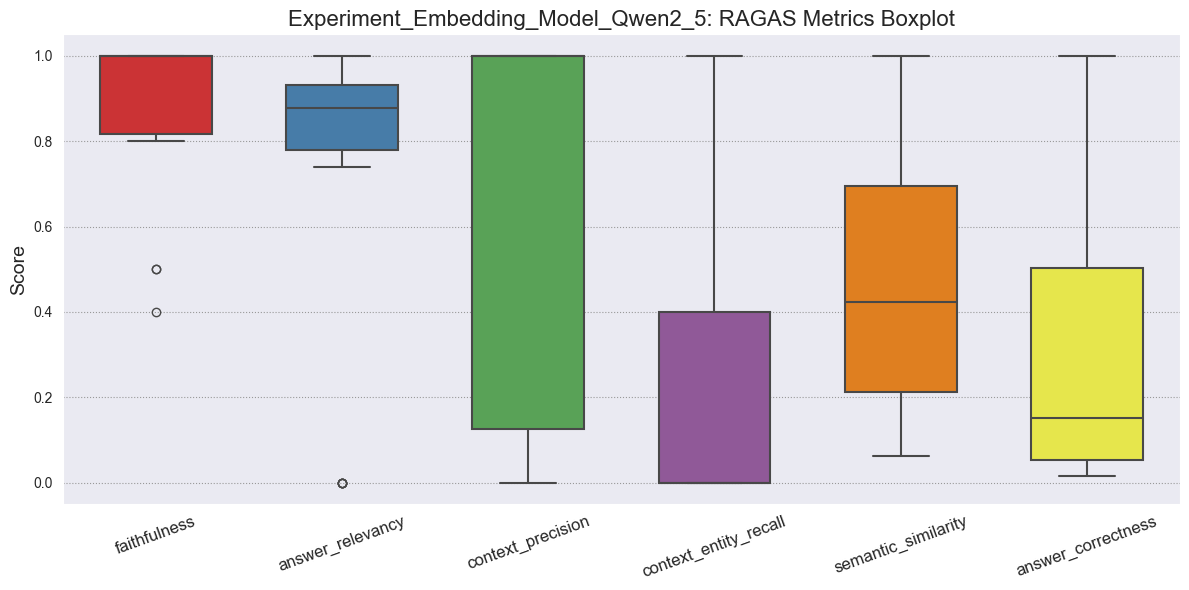

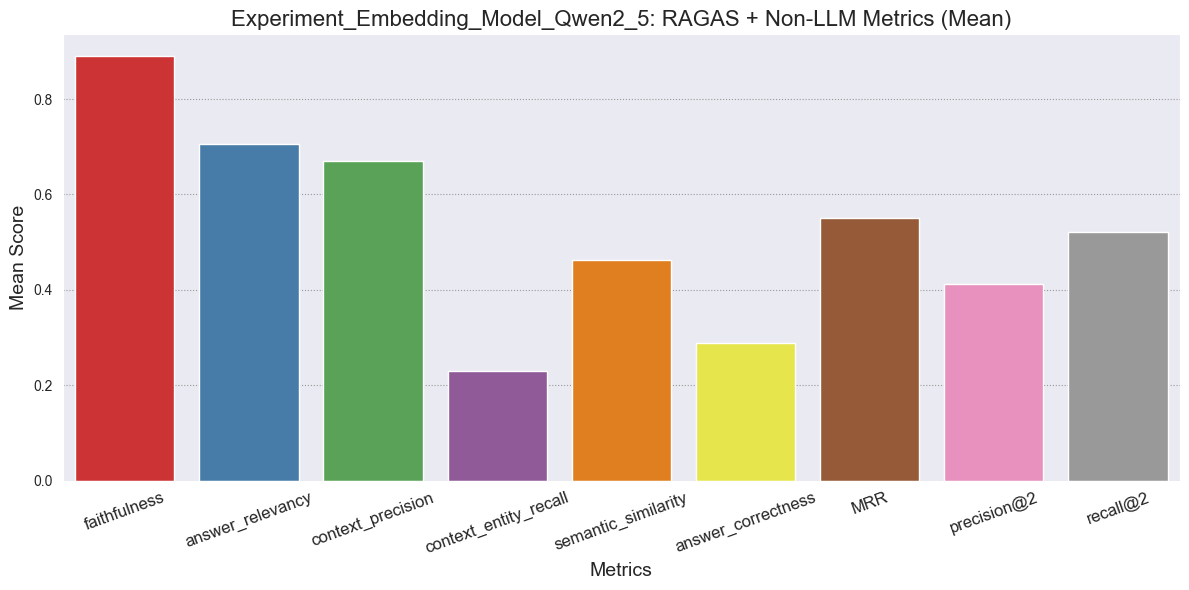

In [28]:
qwen_evaluation.plot_results_all(result_qwen)

In [ ]:
combined_df = utils.add_to_combined("Experiment_Embedding_Qwen2.5", result_qwen, combined_df)

**Insights from the Boxplot**

- Faithfulness: Exhibits a range mostly at the higher end, suggesting strong factual consistency in the answers provided by the model.

- Answer Relevancy: Shows variability with a spread across mid to high values, indicating that while some answers are quite relevant, others may not align as well with the expected context.
   
- Context Precision: Scores highly, implying that the model effectively identifies and utilizes relevant portions of the text in forming responses.
   
- Context Entity Recall: This metric displays some lower scores, pointing to challenges in retrieving all relevant entities from the data.
   
- Semantic Similarity: Varied scores suggest inconsistency in the semantic closeness of the generated answers to the ideal answers.
   
- Answer Correctness: Also varies, with scores indicating that the accuracy and relevancy of answers differ across queries.

**Insights from the Bar Chart**

- Faithfulness and Context Precision have the highest mean scores, reaffirming the model’s ability to stay true to factual content and to pinpoint relevant context.
  
- Answer Relevancy, Context Entity Recall, and Semantic Similarity present moderate scores, highlighting areas where there might be room for improvement.
  
- Answer Correctness has a lower mean, suggesting occasional discrepancies between the generated answers and the ideal responses.
  
- The non-LLM metrics such as MRR, Precision@2, and Recall@2 show a wide range of performance, indicating variability in how effectively the model ranks and retrieves relevant answers.

**Overall**

The Qwen2.5 model demonstrates robust performance in faithfulness and context precision but shows potential weaknesses in entity recall and semantic alignment with the ideal answers. This suggests that while the model is effective at handling direct queries, it may struggle with complexity and nuances in context or phrasing. The moderate scores in MRR and recall metrics suggest that there are opportunities to improve how the system ranks and retrieves the most relevant documents, which could enhance the overall user experience and accuracy of the system.

## <a id='toc11_2_'></a>[Nomic Embedding Model](#toc0_)

Similarly, the `nomic_embed` model is tested under the same conditions. This model’s unique embedding capabilities are expected to demonstrate different aspects of performance, particularly in how it processes and retrieves information.

In [31]:
from src.custom_embeddings import nomic_embed

nomic_vectordb = EmbeddingVectorStorage(
    method_of_embedding=nomic_embed,
    collection="nomic-ai_nomic-embed-text-v1_5_RecursiveCharacterTextSplitter",
    path_persistent=str(PERSISTENT_DIR),
)

print(f"nomic Heartbeat: {nomic_vectordb.test_heartbeat()}, nomic Collection is empty: {nomic_vectordb.collection_is_empty()}")

nomic Heartbeat: 1732251200574044000, nomic Collection is empty: False


In [32]:
nomic_retriever = nomic_vectordb.as_retriever()

nomic_rag_chain = RunnableParallel(
    {"context": nomic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

nomic_rag_chain.invoke("Is Mississipi an anti-ESG state?")

{'context': [Document(metadata={'date': '2023-05-15', 'domain': 'cleantechnica', 'origin_doc_id': '6b8fb712bcb9febe268e3679851e725e', 'title': 'ESG, Much? Mississippi Takes Green Hydrogen To The Next Level', 'url': 'https://cleantechnica.com/2023/05/15/mississippi-takes-green-hydrogen-to-next-level/#zox-comments-button'}, page_content='from renewable energy ventures. , The anti ESG sentiment run deep in Mississippi, at least on the surface. Among those critical of ESG are Governor Tate Reeves, State Treasurer David McRae, both U.S. Senators Roger Wicker and Cindy Hyde Smith, and the three GOP Congressmen, the Tate Record reported on March 21. Nevertheless, one hand doesn t seem to know what the other is doing. , Last November, for example, Governor Reeves proudly announced that Indiana based Steel Dynamics is pumping 2.5 billion into an expansion of its existing campus in Mississippi, under the largest economic development deal in the state s history. Steel Dynamics happens to be a fou

In [33]:
nomic_evaluation = RAGEvaluation(
    name="Experiment_Embedding_Model_Nomic",
    rag_chain=nomic_rag_chain,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=nomic_embed
)

result_nomic = nomic_evaluation.evaluate(clean_file_path, eval_file_path, nomic_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_Embedding_Model_Nomic_qwen2.5:3b-instruct_nomic-ai_nomic-embed-text-v1_5_gpt-4o-mini_eval_result.pkl


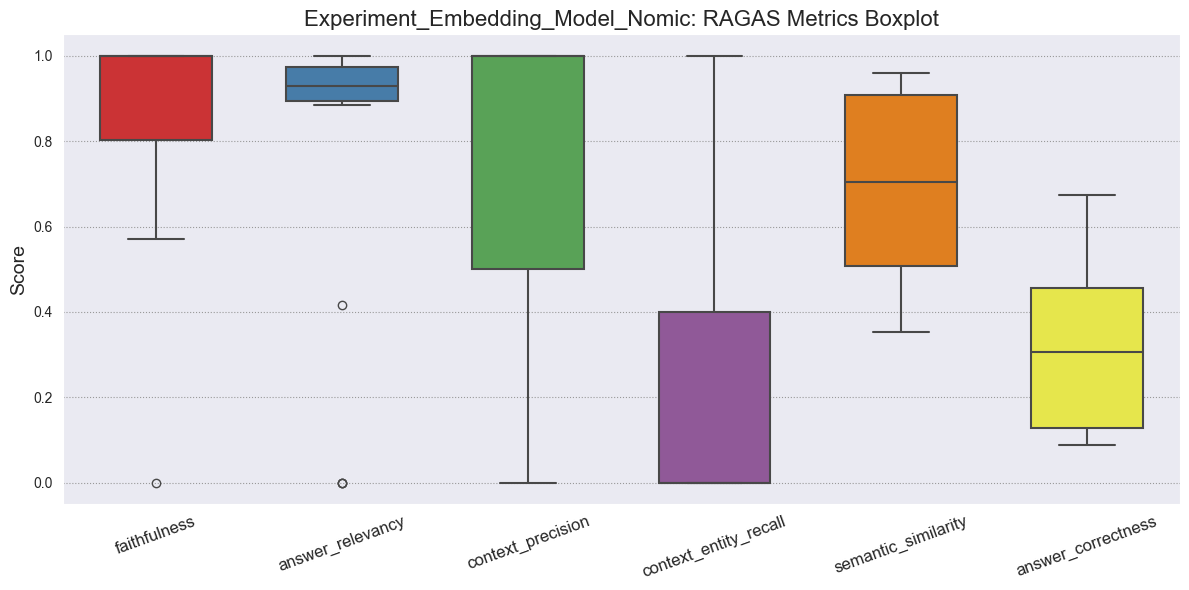

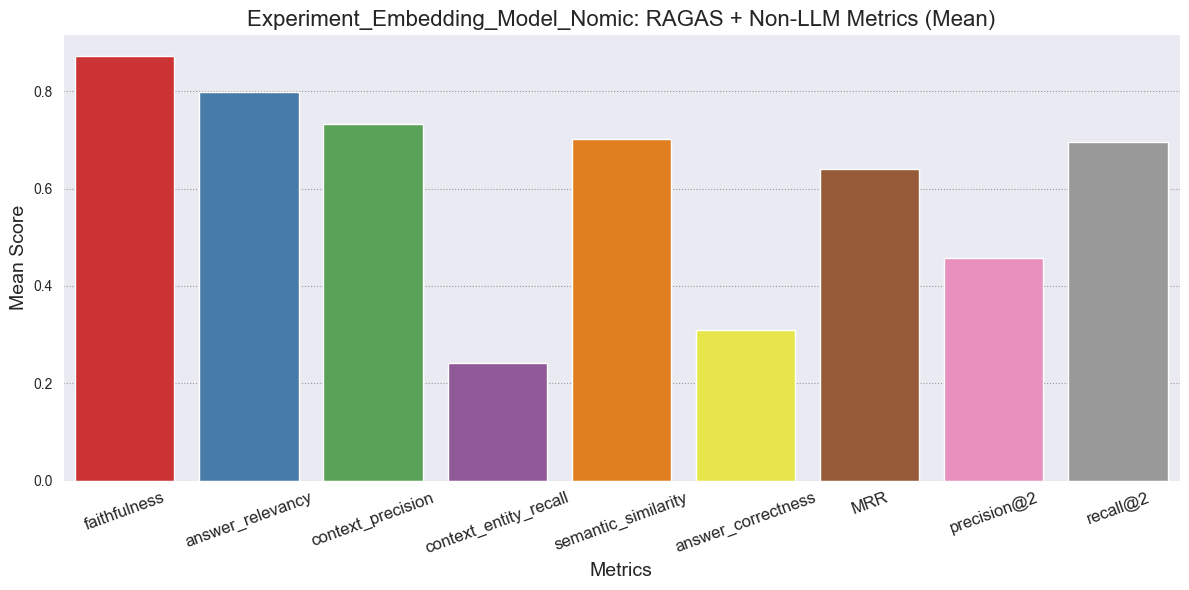

In [34]:
nomic_evaluation.plot_results_all(result_nomic)

In [35]:
combined_df = utils.add_to_combined("Experiment_Embedding_Nomic", result_nomic, combined_df)

**Insights from the Boxplot**

- Faithfulness: Displays a wide range of scores, with some answers highly faithful and others not, suggesting inconsistency in factual accuracy.
  
- Answer Relevancy: Also exhibits significant variability, indicating that while some responses are on point, others may diverge from the expected relevancy.
  
- Context Precision: Scores are high, pointing towards a strong capability of the model to retrieve relevant information from the context.
  
- Context Entity Recall: Shows lower performance, with a significant number of scores below the median, which suggests challenges in retrieving all relevant entities from the context.
  
- Semantic Similarity: The scores are moderate with considerable variability, implying fluctuations in how closely the answers match the semantic expectation.
  
- Answer Correctness: Also shows broad variability, similar to semantic similarity, which indicates fluctuating alignment with the ideal answers.

**Insights from the Bar Chart**

- Faithfulness, Answer Relevancy, and Context Precision show relatively high mean scores, reflecting strong performance in these areas overall, despite the variability shown in the boxplot.
  
- Context Entity Recall and Semantic Similarity demonstrate lower mean scores, identifying them as areas needing improvement.
  
- Answer Correctness shows a moderate mean score, which along with high variability suggests that the model’s performance can greatly differ depending on the specific context or query.
  
- Non-LLM Metrics like MRR, Precision@2, and Recall@2 also exhibit a range of scores, indicating variability in retrieval effectiveness.

**Overall**

The Nomic model excels in precision but struggles with consistency in entity recall and semantic alignment, which are critical for fully understanding and responding to complex queries. The substantial variance in faithfulness and relevancy scores suggests that while the model can perform well in certain contexts, its performance might not be uniformly reliable across different types of queries.

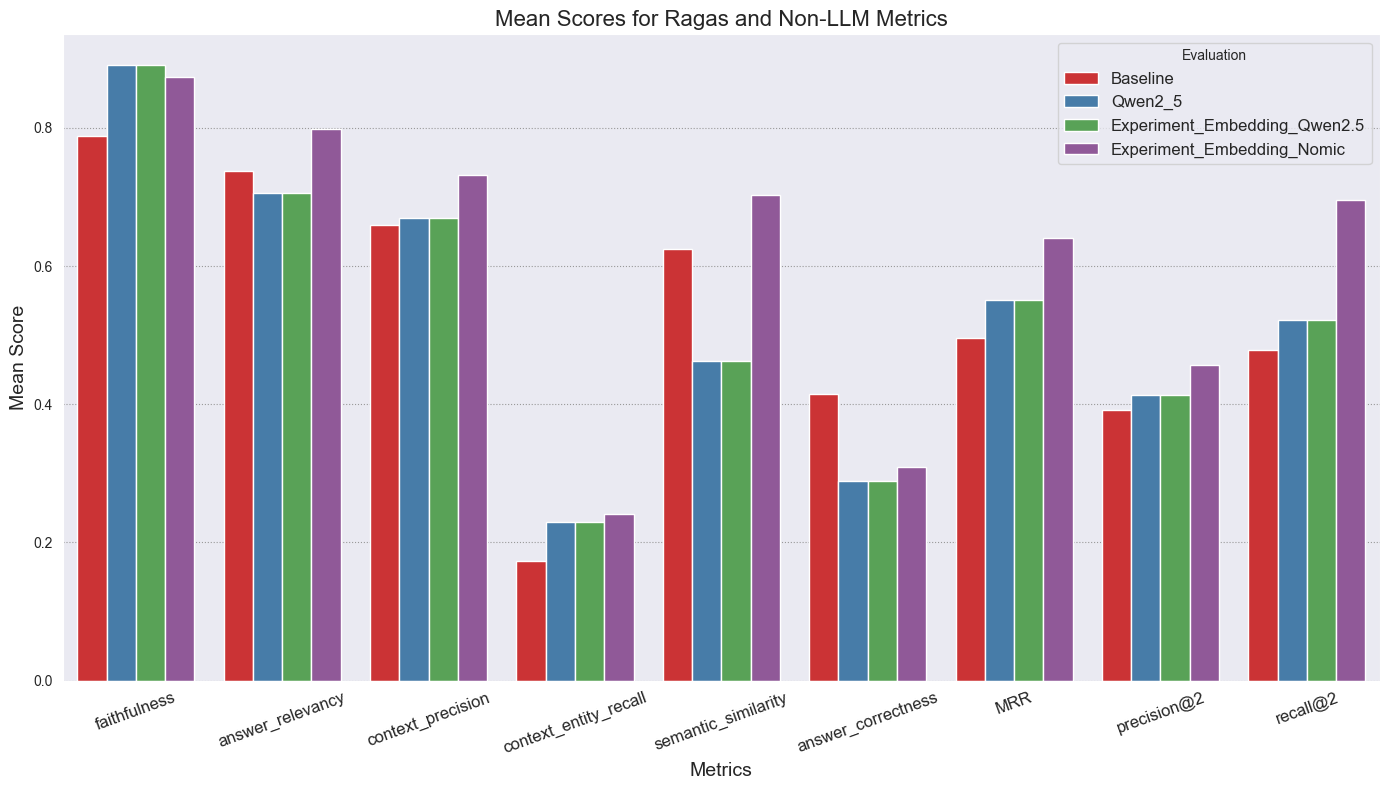

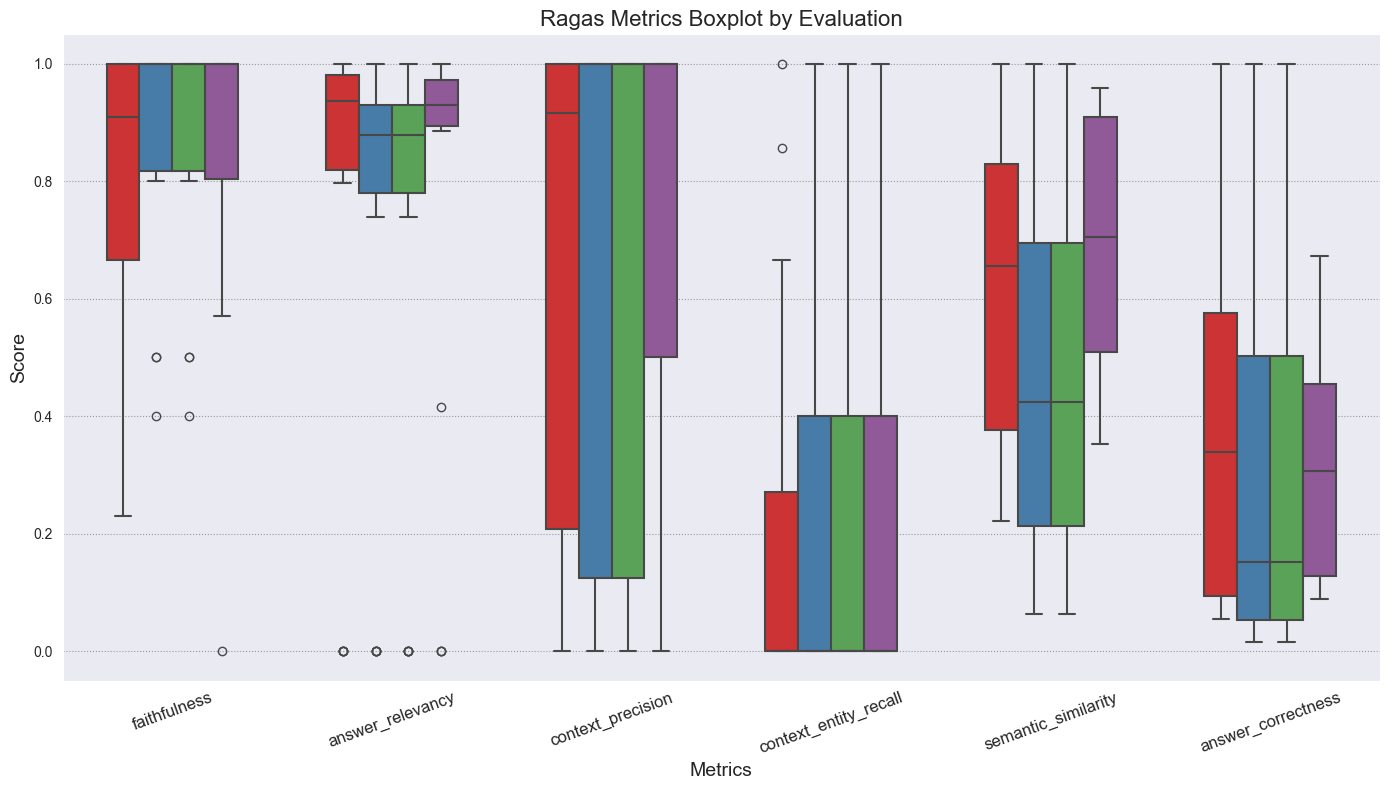

In [36]:
utils.plot_compare_result(combined_df)

**Insights from the Boxplot**

- Faithfulness: Most configurations maintain high median faithfulness, showing that the responses are generally factually consistent with the provided contexts.

- Answer Relevancy: There’s noticeable variability in how relevant the answers are across different setups. Some experiments, particularly those involving nomic embeddings, show higher medians and tighter distributions, indicating more consistently relevant answers.

- Context Precision: This metric has a high median across most configurations. However, the methods show a broader spread, indicating less consistency.

- Context Entity Recall: Significant variations are evident here, with some configurations struggling to recall relevant entities effectively, as shown by lower medians and wider distributions. This suggests that while some setups are effective at precision, they may not always capture the full range of relevant entities.

- Semantic Similarity: The distributions here vary widely, with some configurations showing high medians and others much lower. This suggests that the ability to capture semantic essence varies significantly based on the configuration, with some setups providing responses that are more semantically aligned with the ground truth than others.

- Answer Correctness: Similar to semantic similarity, there is a wide range of performance in answer correctness, with some configurations showing robust correctness and others showing potential weaknesses. This indicates the need for targeted improvements in answer generation or verification mechanisms in some setups.

**Insights from the Bar Chart**

- Faithfulness: The qwen and nomic embeddings generally perform well, with the baseline lagging, indicating that specialized embeddings can sometimes maintain better factual accuracy in responses.

- Answer Relevancy: The nomic embedding stands out as the most effective in providing relevant answers, a crucial factor for user satisfaction in query-response systems.

- Context Precision and Entity Recall: The nomic embedding shows strength in precision but not as much in recall, suggesting its effectiveness in fetching relevant but not comprehensive sets of entities or details.

- Semantic Similarity and Answer Correctness: The nomic embedding again leads in semantic similarity, which correlates with its strong performance in other relevancy and precision metrics. However, all models show room for improvement in ensuring that answers are not only semantically similar but also correct and comprehensive.

- Non-LLM Metrics (MRR, Precision@2, Recall@2): The nomic configuration performs robustly, reflecting its effectiveness in navigating the vector space to retrieve and rank the most relevant documents or context pieces.

**Overall**

The evaluation underscores the importance of choosing the right embedding model and chunking strategy based on the specific needs of the retrieval and response system. While nomic generally shows strong performance across many metrics.


# <a id='toc12_'></a>[Experiment chunking strategies:](#toc0_)

In this section, we explore different chunking strategies to optimize text processing for our Retrieval-Augmented Generation (RAG) system. The goal is to determine the most effective configuration by testing various chunk sizes and overlap parameters. We employ two primary chunking strategies:

- RecursiveCharacterTextSplitter: This method is tested with three configurations:
  - Chunk size of 1000 and overlap of 0: Used in previous experiments, providing a control for comparison.
  - Chunk size of 500 and overlap of 100: Allows for overlapping text chunks, which may help in retaining context across chunks and potentially improve the model’s ability to generate relevant answers by preserving more contextual information.
- SemanticChunker: Utilizes a breakpoint percentile to naturally segment texts based on semantic breakpoints. This strategy potentially improves the relevance of retrieved content by aligning chunks more closely with semantic boundaries, offering a more nuanced approach to text segmentation.

## <a id='toc12_1'></a>[Recursive Chunking(500/100):](#toc0_)

In [37]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

data = pd.read_parquet(str(CLEAN_FILE_PATH))

recursive_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
)

documents = utils.create_documents(data, recursive_text_splitter)

RecursiveCharacterTextSplitter: Documents created: 118062, Rows: 9583, Percentage of doc created: 1231.99%


In [39]:
bge_m3_vectordb_recr_500 = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection='BAAI_bge_m3_RecursiveSplitter_500',
    path_persistent=str(PERSISTENT_DIR)
)

print(f"bge_m3_vectordb_recr_500 Heartbeat: {bge_m3_vectordb_recr_500.test_heartbeat()}, bge_m3_vectordb_recr_500 Collection is empty: {bge_m3_vectordb_recr_500.collection_is_empty()}")

bge_m3_vectordb_recr_500 Heartbeat: 1732251716915951000, bge_m3_vectordb_recr_500 Collection is empty: False


In [40]:
bge_m3_retriever_recr_500 = bge_m3_vectordb_recr_500.as_retriever()

bge_m3_rag_chain_recr_500 = RunnableParallel(
    {"context": bge_m3_retriever_recr_500, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

bge_m3_rag_chain_recr_500.invoke("Is Mississipi an anti-ESG state?")

{'context': [Document(metadata={'date': '2023-05-15', 'domain': 'cleantechnica', 'origin_doc_id': '6b8fb712bcb9febe268e3679851e725e', 'title': 'ESG, Much? Mississippi Takes Green Hydrogen To The Next Level', 'url': 'https://cleantechnica.com/2023/05/15/mississippi-takes-green-hydrogen-to-next-level/#zox-comments-button'}, page_content='of Mississippi, where the firm Hy Stor Energy is working on a plan to transform the Magnolia State into a green hydrogen powerhouse. , Mississippi is among two dozen or so states in which Republican governors, legislators, treasurers, and attorneys general have been railing against ESG environmental, social governance corporate risk management principles. As for why, that s not a mystery. In the context of climate change, one key way to manage risk is to decarbonize. Fossil energy stakeholders'),
  Document(metadata={'date': '2023-05-15', 'domain': 'cleantechnica', 'origin_doc_id': '6b8fb712bcb9febe268e3679851e725e', 'title': 'ESG, Much? Mississippi Take

In [41]:
bge_m3_recr_500_evaluation = RAGEvaluation(
    name="Experiment_2_bge_m3_recr_500",
    rag_chain=bge_m3_rag_chain_recr_500,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=bge_m3_embed
)

result_bge_m3_recr_500 = bge_m3_recr_500_evaluation.evaluate(clean_file_path, eval_file_path, bge_m3_vectordb_recr_500)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_bge_m3_recr_500_qwen2.5:3b-instruct_BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


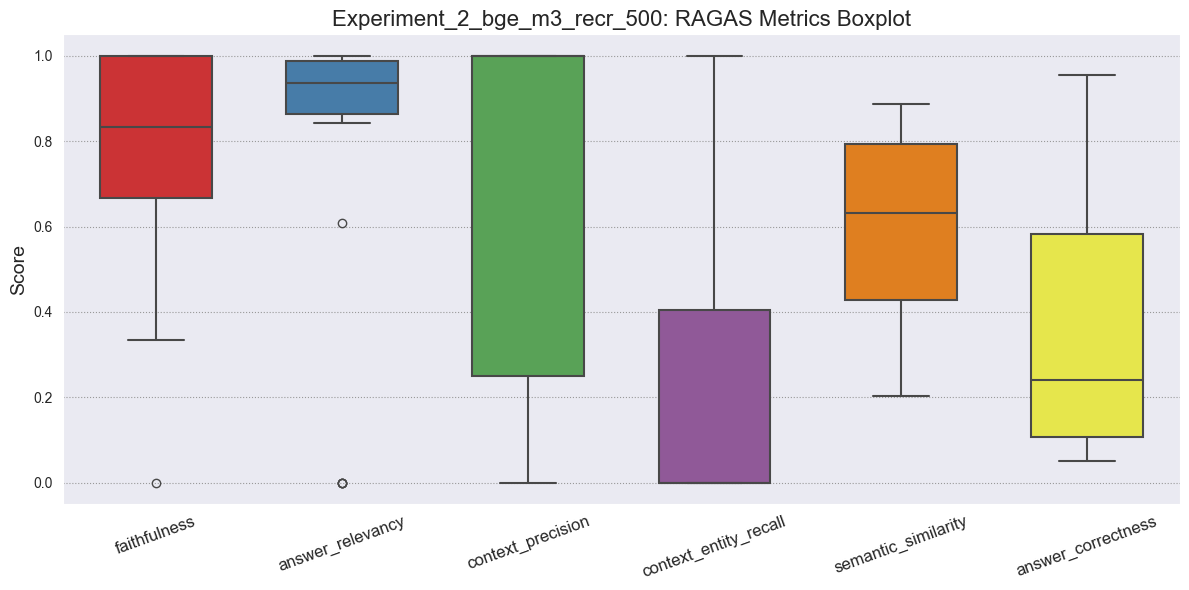

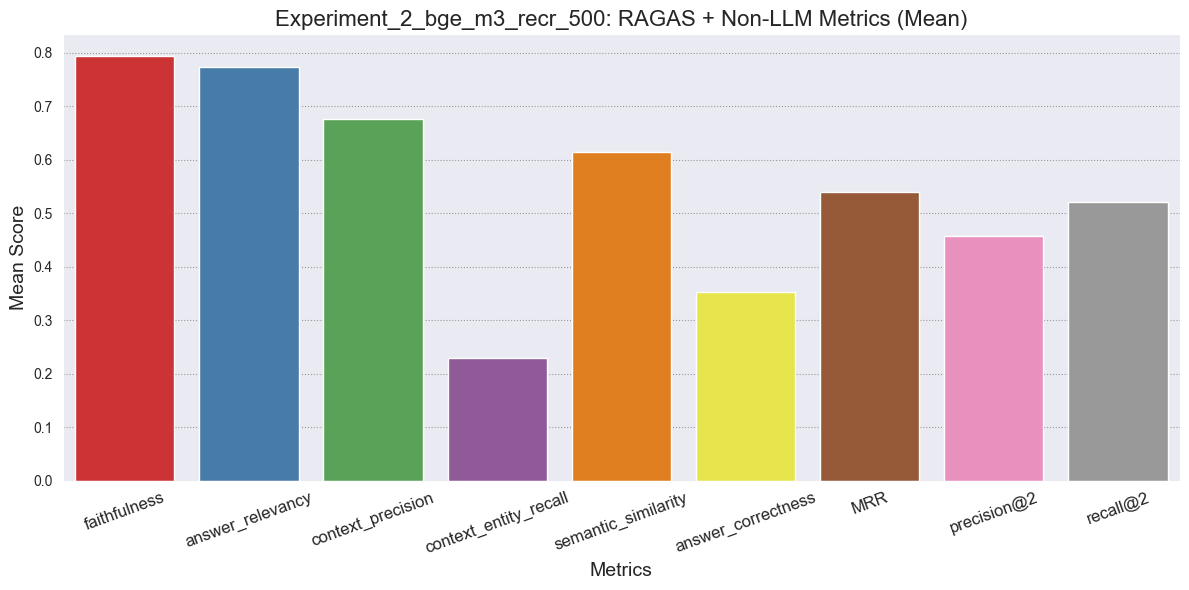

In [42]:
bge_m3_recr_500_evaluation.plot_results_all(result_bge_m3_recr_500)

**Insights from the Boxplot**

- Faithfulness: The model exhibits a consistent high performance in faithfulness, with the majority of the scores clustering near the top, indicating that the answers are factually consistent with the provided context.

- Answer Relevancy: Displays moderate variability, suggesting that while some answers align closely with the query, others do not, which could be due to the increased overlap causing some noise in context retrieval.

- Context Precision: Scores highly, which is expected as smaller chunks with overlaps may improve the precision by capturing more relevant snippets of text.

- Context Entity Recall: This metric shows a lower median score, indicating some difficulties in capturing all relevant entities, perhaps due to the fragmented nature of smaller chunks.

- Semantic Similarity: Exhibits significant variability, reflecting inconsistency in the semantic alignment of answers with the expected responses.

- Answer Correctness: Like semantic similarity, this metric also shows considerable spread and lower median values, suggesting that correct answers vary widely in their alignment with the ground truth.

**Insights from the Mean Scores Bar Chart**

- Faithfulness and Context Precision display strong performance, suggesting that the overlapping chunks may help retain important contextual information leading to factually consistent responses.

- Answer Relevancy and Semantic Similarity show lower scores compared to faithfulness and precision, which could indicate issues with maintaining the integrity of content in smaller, overlapping segments.

- Context Entity Recall and Answer Correctness are the lower-scoring metrics, highlighting potential areas for improvement in ensuring that all pertinent information is captured and correctly utilized in responses.

- Non-LLM Metrics such as MRR, Precision@2, and Recall@2 demonstrate reasonable performance, with room for improvement in retrieval accuracy and ranking relevant documents higher.

**Overall**

This chunking strategy shows a mixed impact on the RAG system’s performance. While it aids in enhancing the precision of context retrieval, it seems to struggle with maintaining entity recall and semantic alignment in some cases. The overlap may contribute to better capturing of context but at the cost of potentially introducing noise, which could affect relevancy and correctness.

In [43]:
combined_df = utils.add_to_combined("Experiment_2_bge_m3_recr_500", result_bge_m3_recr_500, combined_df)

In [44]:
qwen2_5_vectordb_recr_500 = EmbeddingVectorStorage(
    method_of_embedding=qwen2_embed,
    collection='Alibaba-NLP_gte-Qwen2-7B_RecursiveSplitter_500',
    path_persistent=str(PERSISTENT_DIR)
)

print(f"qwen2_5_vectordb_recr_500 Heartbeat: {qwen2_5_vectordb_recr_500.test_heartbeat()}, qwen2_5_vectordb_recr_500 Collection is empty: {qwen2_5_vectordb_recr_500.collection_is_empty()}")

qwen2_5_vectordb_recr_500 Heartbeat: 1732251896400748000, qwen2_5_vectordb_recr_500 Collection is empty: False


In [45]:
qwen2_5_retriever_recr_500 = qwen2_5_vectordb_recr_500.as_retriever()

qwen2_5_rag_chain_recr_500 = RunnableParallel(
    {"context": qwen2_5_retriever_recr_500, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

qwen2_5_rag_chain_recr_500.invoke("Is Mississipi an anti-ESG state?")

{'context': [Document(metadata={'date': '2023-05-15', 'domain': 'cleantechnica', 'origin_doc_id': '6b8fb712bcb9febe268e3679851e725e', 'title': 'ESG, Much? Mississippi Takes Green Hydrogen To The Next Level', 'url': 'https://cleantechnica.com/2023/05/15/mississippi-takes-green-hydrogen-to-next-level/#zox-comments-button'}, page_content='context of climate change, one key way to manage risk is to decarbonize. Fossil energy stakeholders and their allies in public office have been pushing back, by trying to steer investor dollars away from renewable energy ventures. , The anti ESG sentiment run deep in Mississippi, at least on the surface. Among those critical of ESG are Governor Tate Reeves, State Treasurer David McRae, both U.S. Senators Roger Wicker and Cindy Hyde Smith, and the three GOP Congressmen, the Tate Record reported'),
  Document(metadata={'date': '2023-05-15', 'domain': 'cleantechnica', 'origin_doc_id': '6b8fb712bcb9febe268e3679851e725e', 'title': 'ESG, Much? Mississippi Take

In [46]:
qwen2_5_recr_500_evaluation = RAGEvaluation(
    name="Experiment_2_qwen2_5_recr_500",
    rag_chain=qwen2_5_rag_chain_recr_500,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=qwen2_embed
)

result_qwen2_5_recr_500 = qwen2_5_recr_500_evaluation.evaluate(clean_file_path, eval_file_path, qwen2_5_vectordb_recr_500)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_qwen2_5_recr_500_qwen2.5:3b-instruct_Alibaba-NLP_gte-Qwen2-7B_gpt-4o-mini_eval_result.pkl


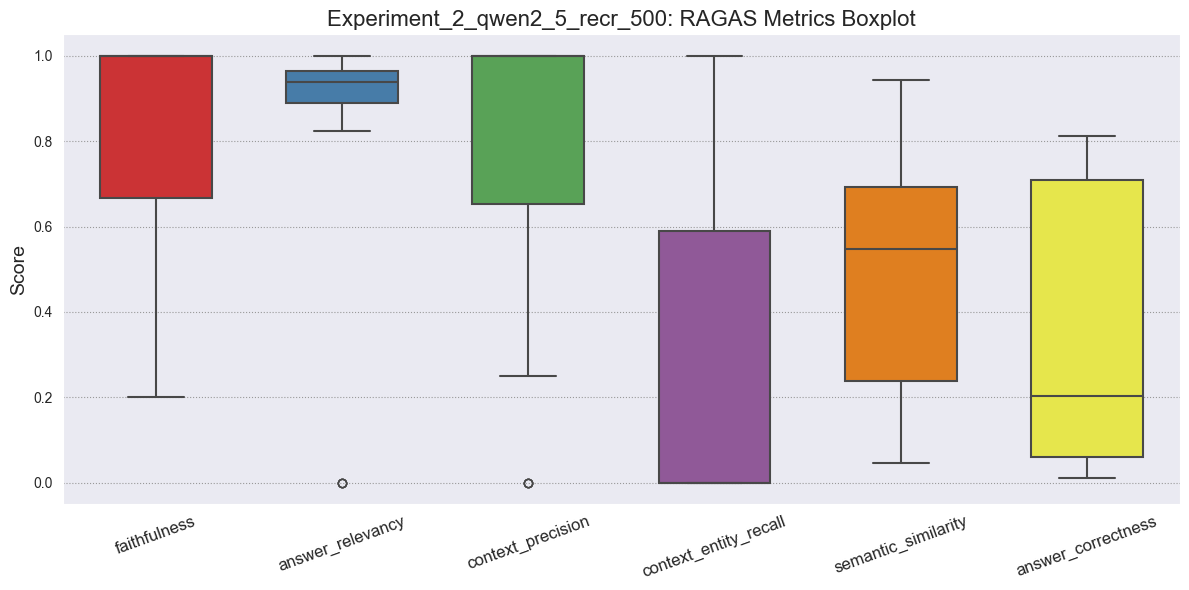

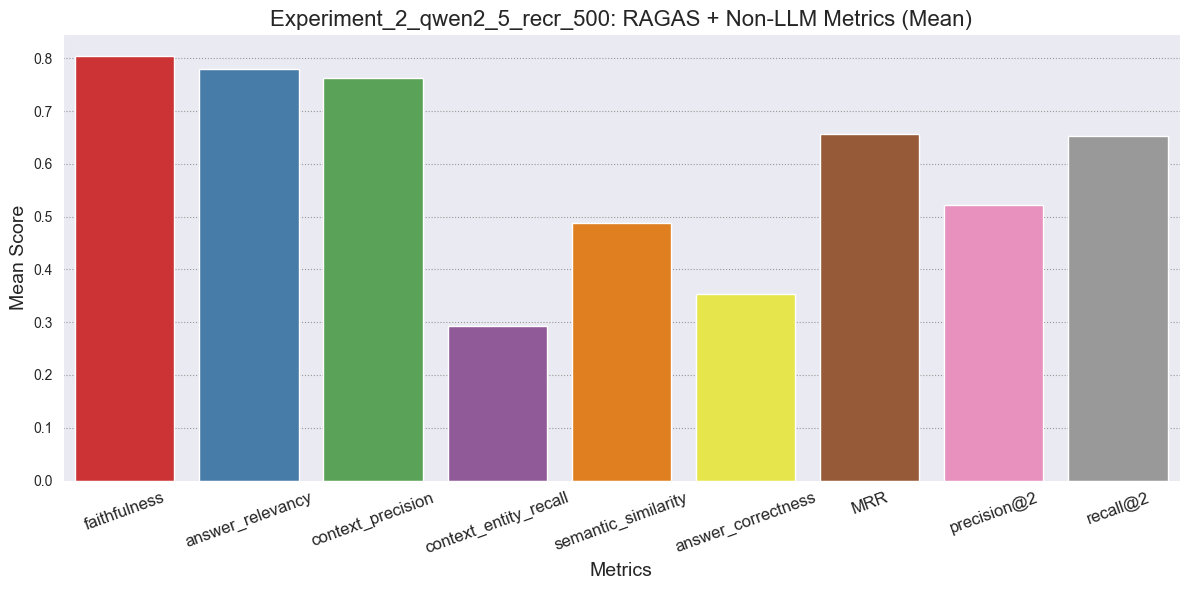

In [47]:
qwen2_5_recr_500_evaluation.plot_results_all(result_qwen2_5_recr_500)

In [48]:
combined_df = utils.add_to_combined("Experiment_2_qwen2_5_recr_500", result_qwen2_5_recr_500, combined_df)

**Insights from the Boxplot**

- Faithfulness: Demonstrates high consistency, with the majority of scores near the maximum. This indicates strong factual alignment of the generated answers with the provided contexts.

- Answer Relevancy: Shows a narrower spread compared to other metrics, indicating a generally high and consistent relevancy of answers to the questions.

- Context Precision: This metric is exceptionally high, suggesting that the system effectively identifies and utilizes the most relevant parts of the text.

- Context Entity Recall: Exhibits some variability and a slightly lower median, pointing to challenges in consistently recalling all relevant entities.

- Semantic Similarity: The variability seen here suggests that while some answers closely match the semantic intent of the ideal answers, others do not.

- Answer Correctness: Like semantic similarity, this metric shows considerable variability and a lower median, indicating that the correctness of the answers varies.

**Insights from the Mean Scores Bar Chart**

- Faithfulness, Answer Relevancy, and Context Precision display strong performance, indicating that the model generally produces factually accurate and relevant responses and precisely retrieves relevant context.

- Context Entity Recall and Semantic Similarity are lower, highlighting areas where improvements could be beneficial, especially in ensuring that all pertinent entities are captured and the semantic content of answers aligns well with the ideal responses.

- Answer Correctness shows moderate performance, suggesting that the quality of the answers in terms of both factuality and relevancy could be inconsistent.

- Non-LLM Metrics (MRR, Precision@2, Recall@2) show a spectrum of outcomes, suggesting variability in how effectively the model ranks and retrieves the first relevant answers.

**Overall**

The analysis reveals that the Qwen2.5 model performs well in terms of faithfulness, relevancy, and precision when using a chunking strategy with smaller chunks and overlaps. However, it faces challenges with entity recall and semantic similarity, which are crucial for generating fully accurate and contextually appropriate answers. The variability in answer correctness and semantic similarity indicates that while the model can handle some queries exceptionally well, it may struggle with others, potentially due to how information is distributed across overlapping chunks.

In [49]:
nomic_vectordb_recr_500 = EmbeddingVectorStorage(
    method_of_embedding=nomic_embed,
    collection='nomic-ai_nomic-embed-text-v1_5_RecursiveSplitter_500',
    path_persistent=str(PERSISTENT_DIR)
)

print(f"nomic_vectordb_recr_500 Heartbeat: {nomic_vectordb_recr_500.test_heartbeat()}, nomic_vectordb_recr_500 Collection is empty: {nomic_vectordb_recr_500.collection_is_empty()}")

nomic_vectordb_recr_500 Heartbeat: 1732251945672474000, nomic_vectordb_recr_500 Collection is empty: False


In [50]:
nomic_retriever_recr_500 = nomic_vectordb_recr_500.as_retriever()

nomic_rag_chain_recr_500 = RunnableParallel(
    {"context": nomic_retriever_recr_500, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

nomic_rag_chain_recr_500.invoke("Is Mississipi an anti-ESG state?")

{'context': [Document(metadata={'date': '2023-06-05', 'domain': 'cleantechnica', 'origin_doc_id': 'c861f680e86a576218ab78f32dd01a85', 'title': 'Be Careful What You Wish For, Electric Vehicle Edition', 'url': 'https://cleantechnica.com/2023/06/05/be-careful-what-you-wish-for-electric-vehicle-edition/'}, page_content='Georgia Governor Brian Kemp also did not get the memo. He signed onto a joint anti ESG statement with 18 other governors dated March 16, railing against the ESG friendly rules. , The proliferation of ESG throughout America is a direct threat to the American economy, individual economic freedom, and our way of life, putting investment decisions in the hands of the woke mob to bypass the ballot box and inject political ideology into investment decisions, corporate governance, and the everyday'),
  Document(metadata={'date': '2023-05-23', 'domain': 'cleantechnica', 'origin_doc_id': '7b6e4059362da735a451bcdcd6260aa5', 'title': 'Massive New Wind Energy Project To Link New Mexico

In [51]:
nomic_recr_500_evaluation = RAGEvaluation(
    name="Experiment_2_nomic_recr_500",
    rag_chain=nomic_rag_chain_recr_500,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=nomic_embed
)

result_nomic_recr_500 = nomic_recr_500_evaluation.evaluate(clean_file_path, eval_file_path, nomic_vectordb_recr_500)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_nomic_recr_500_qwen2.5:3b-instruct_nomic-ai_nomic-embed-text-v1_5_gpt-4o-mini_eval_result.pkl


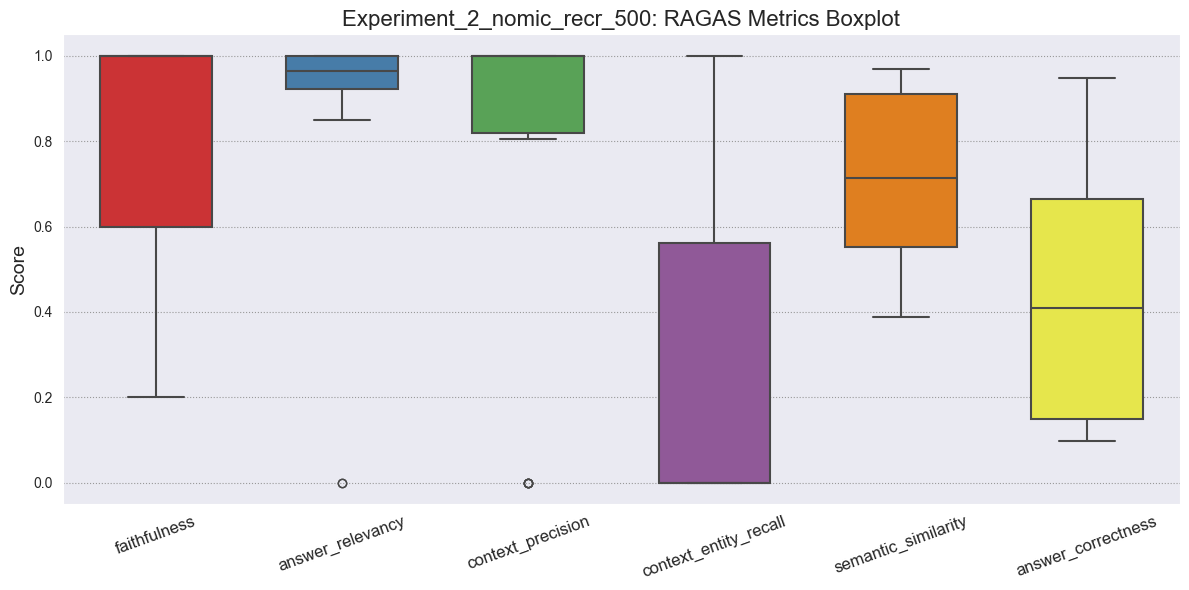

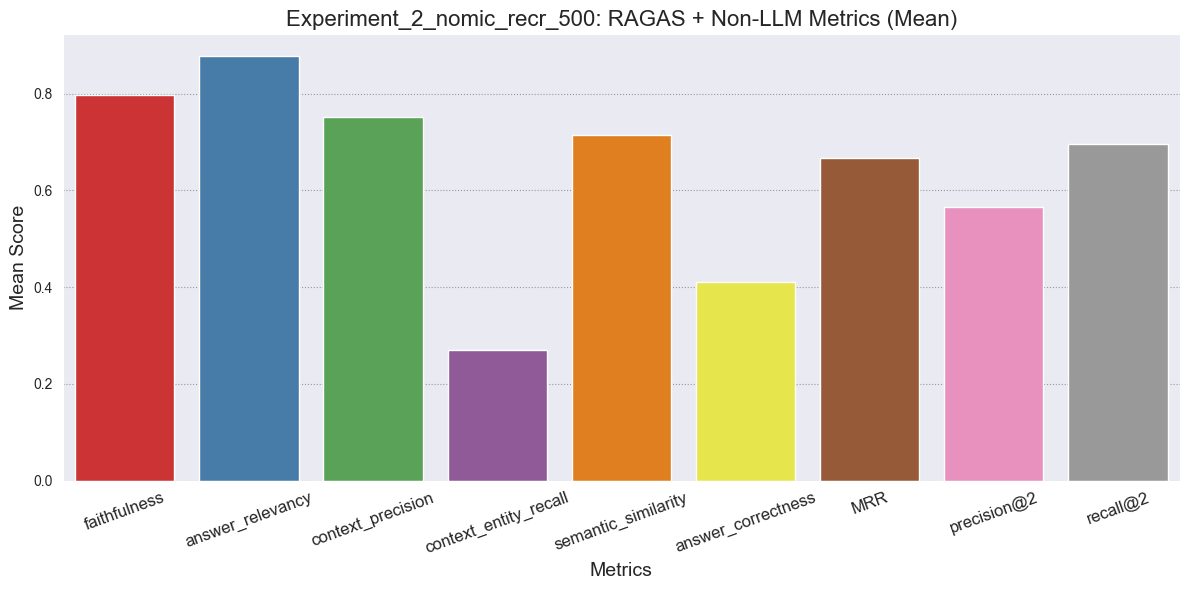

In [52]:
nomic_recr_500_evaluation.plot_results_all(result_nomic_recr_500)

In [53]:
combined_df = utils.add_to_combined("Experiment_2_nomic_recr_500", result_nomic_recr_500, combined_df)

**Insights from the Boxplot**

- Faithfulness: This metric shows a high range of scores, indicating that some answers are perfectly faithful to the given context, while others may deviate.
	
- Answer Relevancy: Exhibits a moderate spread, suggesting variability in how relevant the answers are to the posed questions.

- Context Precision: The scores are high, which indicates that the model effectively uses the context to provide precise answers.

- Context Entity Recall: This metric shows a broad range of outcomes, indicating some inconsistency in capturing all relevant entities within the text.

- Semantic Similarity: There’s significant variability here, suggesting that the semantic alignment of the responses with the expected answers varies.

- Answer Correctness: Displays a wide range of scores. The lower end of the scale suggests that some answers may not fully align with the factual or semantic expectations.

**Insights from the Mean Scores Bar Chart**

- Faithfulness, Answer Relevancy, and Context Precision achieve strong mean scores, indicating that, on average, the responses are factually consistent, relevant to the queries, and precise in context utilization.

- Context Entity Recall and Semantic Similarity display lower average scores, highlighting areas where the model may benefit from improvements to better capture relevant entities and enhance semantic alignment.

- Answer Correctness also shows a moderate average score, pointing to a need for further refinement to ensure answers are consistently accurate.

- Non-LLM Metrics: MRR (Mean Reciprocal Rank), Precision@2, and Recall@2 demonstrate the system’s ability to effectively rank and retrieve relevant answers, though there is room for improvement in these areas.

**Overall**

The Nomic model with this specific chunking strategy shows good performance in precision and relevance but struggles with consistency in entity recall and semantic alignment. The results suggest that while the model is capable of generating high-quality answers under certain conditions, the variability in other metrics indicates potential areas for optimization.

## <a id='toc12_2'></a>[Semantic Chunker:](#toc0_)

In [54]:
bge_m3_semantic_vectordb = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection='BAAI_bge_m3_SemanticChunker',
    path_persistent=str(PERSISTENT_DIR)
)

print(f"bge_m3_semantic_vectordb Heartbeat: {bge_m3_semantic_vectordb.test_heartbeat()}, bge_m3_semantic_vectordb Collection is empty: {bge_m3_semantic_vectordb.collection_is_empty()}")

bge_m3_semantic_vectordb Heartbeat: 1732252018576005000, bge_m3_semantic_vectordb Collection is empty: False


In [55]:
bge_m3_retriever_semantic = bge_m3_semantic_vectordb.as_retriever()

bge_m3_rag_chain_semantic = RunnableParallel(
    {"context": bge_m3_retriever_semantic, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

bge_m3_rag_chain_semantic.invoke("Is Mississipi an anti-ESG state?")

{'context': [Document(metadata={'date': '2023-05-15', 'domain': 'cleantechnica', 'origin_doc_id': '6b8fb712bcb9febe268e3679851e725e', 'title': 'ESG, Much? Mississippi Takes Green Hydrogen To The Next Level', 'url': 'https://cleantechnica.com/2023/05/15/mississippi-takes-green-hydrogen-to-next-level/#zox-comments-button'}, page_content='State office holders in Mississippi continue to spout anti ESG rhetoric, but a massive green hydrogen hub is taking shape right under their feet. , The Energy Department launched an 8 billion hydrogen program last year, and state officials around the nation are scrambling to get a slice of the pie. In some cases they are even putting partisan politics aside. The latest example is the deep red state of Mississippi, where the firm Hy Stor Energy is working on a plan to transform the Magnolia State into a green hydrogen powerhouse. , Mississippi is among two dozen or so states in which Republican governors, legislators, treasurers, and attorneys general hav

In [56]:
bge_m3_semantic_evaluation = RAGEvaluation(
    name="Experiment_2_bge_m3_semantic",
    rag_chain=bge_m3_rag_chain_semantic,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=bge_m3_embed
)

result_bge_m3_semantic = bge_m3_semantic_evaluation.evaluate(clean_file_path, eval_file_path, bge_m3_semantic_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_bge_m3_semantic_qwen2.5:3b-instruct_BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


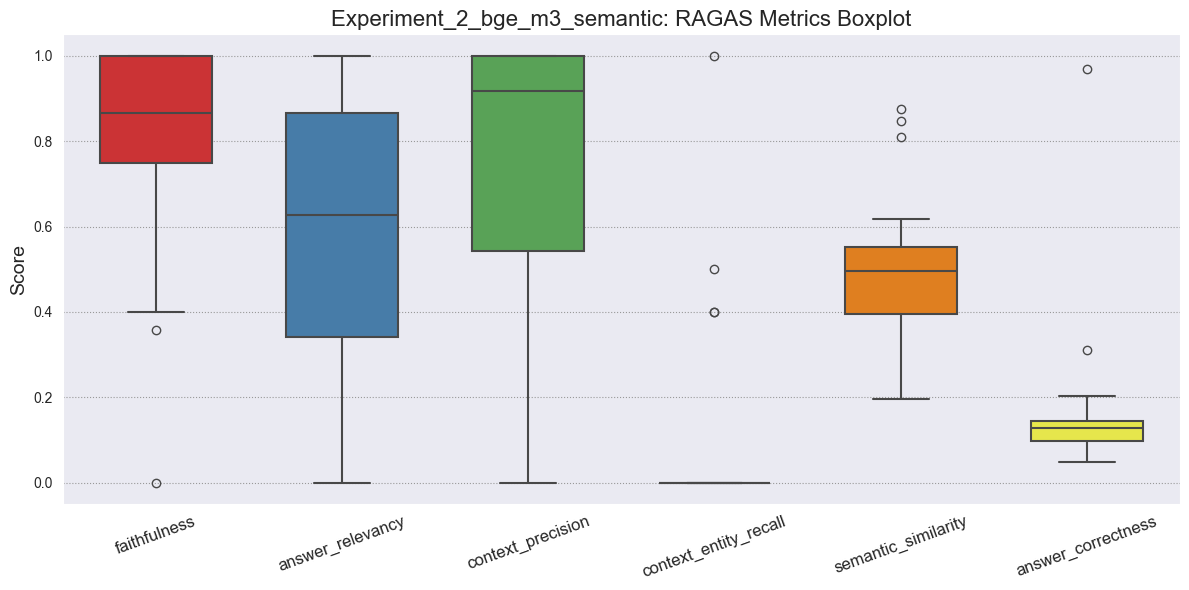

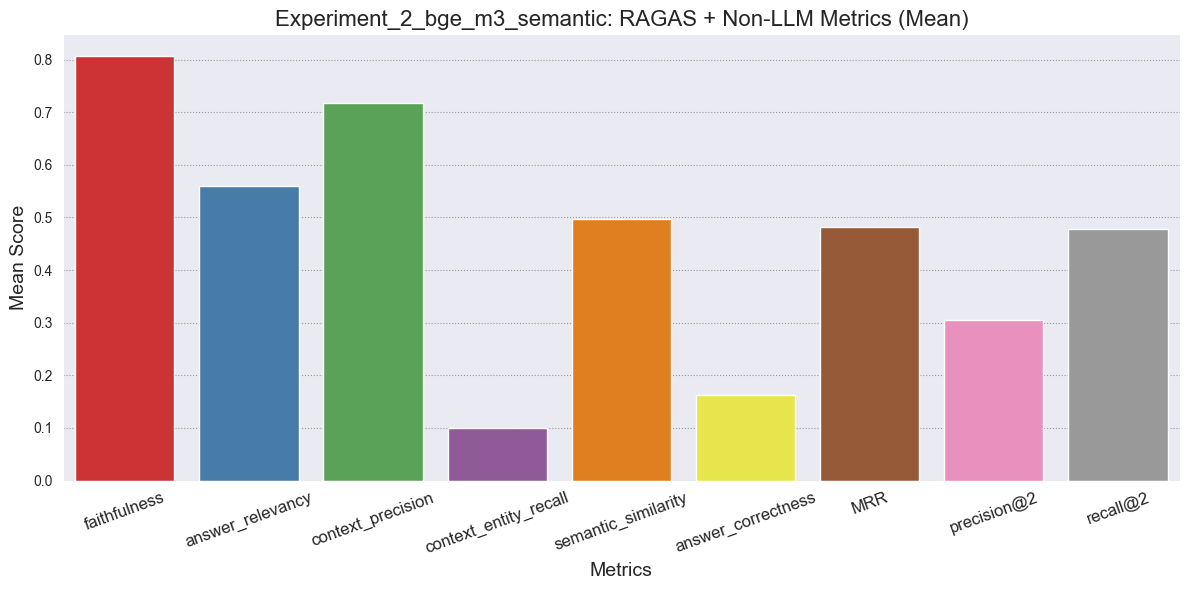

In [57]:
bge_m3_semantic_evaluation.plot_results_all(result_bge_m3_semantic)

In [58]:
combined_df = utils.add_to_combined("Experiment_2_bge_m3_semantic", result_bge_m3_semantic, combined_df)

**Insights from the Boxplot**

- Faithfulness: Displays a high median with less variability compared to other metrics, indicating that most responses are factually consistent with the given contexts.

- Answer Relevancy: Shows a relatively narrow interquartile range, suggesting that the answers generally align well with the questions, albeit with a few outliers indicating less relevancy.

- Context Precision: The scores are uniformly high, which suggests that semantic chunking effectively identifies and utilizes relevant context segments.

- Context Entity Recall: Exhibits significant variability and a lower median, indicating challenges in consistently capturing all relevant entities.

- Semantic Similarity: Shows a wide range of scores, indicating inconsistency in how closely the answers match the semantic intent of the ideal answers.

- Answer Correctness: The distribution is skewed towards lower scores, suggesting that while some answers are correct, there is a significant number of responses that do not entirely align with the expected correctness.

**Insights from the Mean Scores Bar Chart**

- Faithfulness and Context Precision achieve the strongest performance, reflecting the model’s capability to generate responses that are factually accurate and contextually precise.

- Answer Relevancy and Semantic Similarity show good average scores, but the variability indicated in the boxplot suggests that performance can fluctuate.

- Context Entity Recall and Answer Correctness are areas where the model struggles the most, as reflected in both the mean scores and the variability seen in the boxplot.

- Non-LLM Metrics such as MRR, Precision@2, and Recall@2 indicate moderate to good retrieval performance but highlight potential areas for improvement in accurately ranking and retrieving the most relevant documents.

**Overall**

The SemanticChunker shows promising results in certain areas like faithfulness and context precision but struggles with consistency in entity recall and semantic alignment. The high variability in several metrics suggests that while the semantic-based chunking helps in certain aspects, it may introduce complexities that affect other areas of performance, such as semantic similarity and answer correctness.

In [59]:
qwen2_5_semantic_vectordb = EmbeddingVectorStorage(
    method_of_embedding=qwen2_embed,
    collection='Alibaba-NLP_gte-Qwen2-7B_SemanticChunker',
    path_persistent=str(PERSISTENT_DIR)
)

print(f"qwen2_5_semantic_vectordb Heartbeat: {qwen2_5_semantic_vectordb.test_heartbeat()}, qwen2_5_semantic_vectordb Collection is empty: {qwen2_5_semantic_vectordb.collection_is_empty()}")

qwen2_5_semantic_vectordb Heartbeat: 1732252078349109000, qwen2_5_semantic_vectordb Collection is empty: False


In [60]:
qwen2_5_retriever_semantic = qwen2_5_semantic_vectordb.as_retriever()

qwen2_5_rag_chain_semantic = RunnableParallel(
    {"context": qwen2_5_retriever_semantic, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

qwen2_5_rag_chain_semantic.invoke("Is Mississipi an anti-ESG state?")

{'context': [Document(metadata={'date': '2023-05-15', 'domain': 'cleantechnica', 'origin_doc_id': '6b8fb712bcb9febe268e3679851e725e', 'title': 'ESG, Much? Mississippi Takes Green Hydrogen To The Next Level', 'url': 'https://cleantechnica.com/2023/05/15/mississippi-takes-green-hydrogen-to-next-level/#zox-comments-button'}, page_content='Nevertheless, one hand doesn t seem to know what the other is doing. , Last November, for example, Governor Reeves proudly announced that Indiana based Steel Dynamics is pumping 2.5 billion into an expansion of its existing campus in Mississippi, under the largest economic development deal in the state s history. Steel Dynamics happens to be a founding member of the Global Steel Climate Council, which has proposed a new standard for greenhouse gas transparency in the steel industry. , This new standard will accelerate the actual reduction of greenhouse gas emissions and provide key decisionmakers with transparent and consistent data to make informed deci

In [61]:
qwen2_5_semantic_evaluation = RAGEvaluation(
    name="Experiment_2_qwen2_5_semantic",
    rag_chain=qwen2_5_rag_chain_semantic,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=qwen2_embed
)

result_qwen2_5_semantic = qwen2_5_semantic_evaluation.evaluate(clean_file_path, eval_file_path, qwen2_5_semantic_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_qwen2_5_semantic_qwen2.5:3b-instruct_Alibaba-NLP_gte-Qwen2-7B_gpt-4o-mini_eval_result.pkl


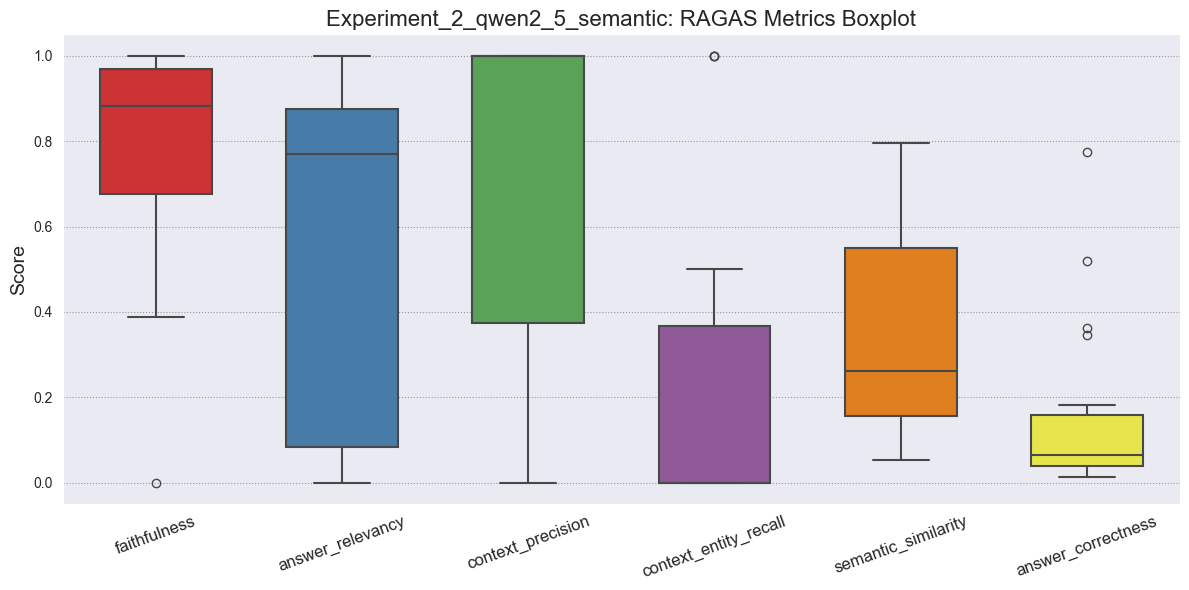

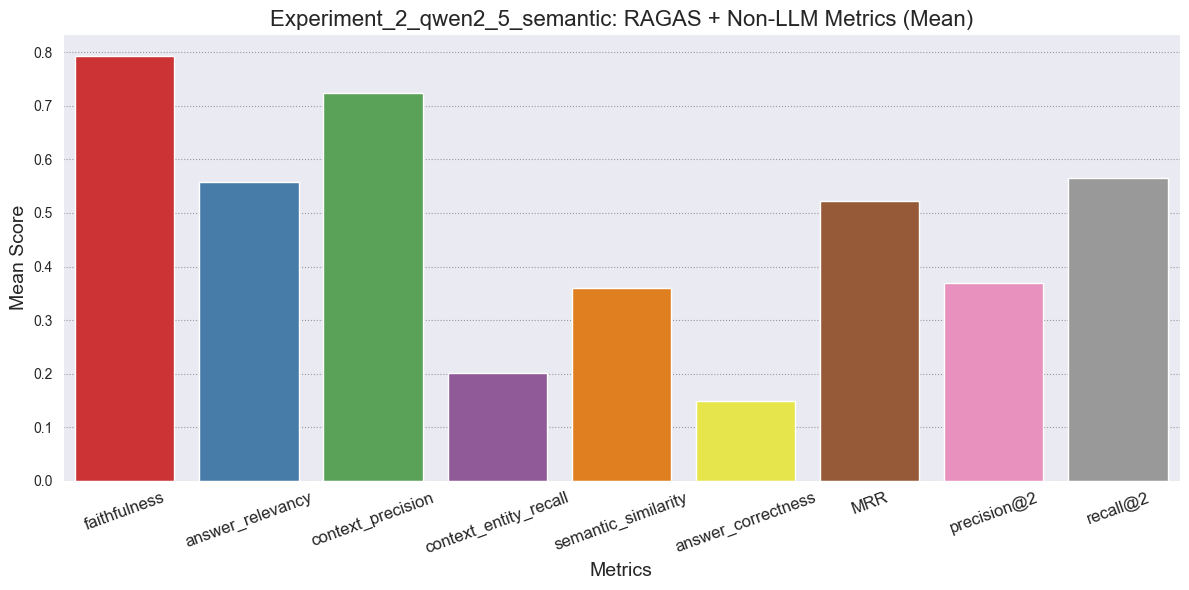

In [62]:
qwen2_5_semantic_evaluation.plot_results_all(result_qwen2_5_semantic)

In [63]:
combined_df = utils.add_to_combined("Experiment_2_qwen2_5_semantic", result_qwen2_5_semantic, combined_df)

**Insights from the Boxplot**

- Faithfulness: Displays very high scores, indicating strong factual consistency in the answers with the provided context. The narrow interquartile range suggests consistent performance across different queries.

- Answer Relevancy: Exhibits less variability than faithfulness, with most scores indicating high relevancy, though there are outliers indicating occasional misalignments.

- Context Precision: The high median and small interquartile range suggest that the system effectively identifies and utilizes relevant parts of the text.

- Context Entity Recall: Shows a broader range, indicating variability in the model’s ability to consistently capture all relevant entities.

- Semantic Similarity: This metric has a wide range, suggesting some answers align closely with the semantic intent of ideal answers, while others do not.

- Answer Correctness: The variability seen here, with a number of outliers on the lower end, indicates inconsistencies in how accurately the answers reflect the ideal responses.

**Insights from the Mean Scores Bar Chart**

- Faithfulness and Context Precision are the highest-performing metrics, affirming the model’s ability to produce factually accurate and contextually precise responses.

- Answer Relevancy also shows a strong average performance, though the boxplot indicates occasional deviations from ideal relevancy.

- Context Entity Recall and Semantic Similarity present challenges, as indicated by their lower average scores and wider ranges in the boxplot, suggesting areas where the model could benefit from further refinement.

- Answer Correctness shows moderate performance, corroborating the boxplot’s indication of variability in correctness.

- Non-LLM Metrics like MRR, Precision@2, and Recall@2 suggest good retrieval effectiveness but also highlight potential areas for improvement in ranking and retrieving the most relevant documents.

**Overall**

The SemanticChunker used with the Qwen2.5 model exhibits strong performance in faithfulness and context precision but struggles with consistency in entity recall and semantic alignment. The significant variance in some metrics suggests that while the semantic-based chunking helps in certain aspects, it may introduce complexities that affect other areas of performance, such as semantic similarity and answer correctness.

In [64]:
nomic_semantic_vectordb = EmbeddingVectorStorage(
    method_of_embedding=nomic_embed,
    collection='nomic-ai_nomic-embed-text-v1_5_SemanticChunker',
    path_persistent=str(PERSISTENT_DIR)
)

print(f"nomic_semantic_vectordb Heartbeat: {nomic_semantic_vectordb.test_heartbeat()}, nomic_semantic_vectordb Collection is empty: {nomic_semantic_vectordb.collection_is_empty()}")

nomic_semantic_vectordb Heartbeat: 1732252117822390000, nomic_semantic_vectordb Collection is empty: False


In [66]:
nomic_retriever_semantic = nomic_semantic_vectordb.as_retriever()

nomic_rag_chain_semantic = RunnableParallel(
    {"context": nomic_retriever_semantic, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

nomic_rag_chain_semantic.invoke("Is Mississipi an anti-ESG state?")

{'context': [Document(metadata={'date': '2023-05-11', 'domain': 'cleantechnica', 'origin_doc_id': '6726c40378bf6c4b7099f744744d3395', 'title': 'NextEra Energy Blows Green Hydrogen Raspberry At ESG Foes', 'url': 'https://cleantechnica.com/2023/05/11/nextera-blows-green-hydrogen-raspberry-at-renewable-energy-foes/'}, page_content='If you can spot others, drop us a note in the comment thread. , The irony is especially delicious when the state in question is Florida, where Republican Governor Ron DeSantis recently signed an anti ESG bill into law. , Today, Governor Ron DeSantis was joined by Senate President Kathleen Passidomo and House Speaker Paul Renner to announce comprehensive legislation to protect Floridians from the woke environmental, social, and corporate governance ESG movement that continues to proliferate throughout the financial sector, the Governor s office announced on February 13, when the bill was introduced. , Apparently NextEra Energy did not get the memo.'),
  Document

In [67]:
nomic_semantic_evaluation = RAGEvaluation(
    name="Experiment_2_nomic_semantic",
    rag_chain=nomic_rag_chain_semantic,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=nomic_embed
)

result_nomic_semantic = nomic_semantic_evaluation.evaluate(clean_file_path, eval_file_path, nomic_semantic_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_nomic_semantic_qwen2.5:3b-instruct_nomic-ai_nomic-embed-text-v1_5_gpt-4o-mini_eval_result.pkl


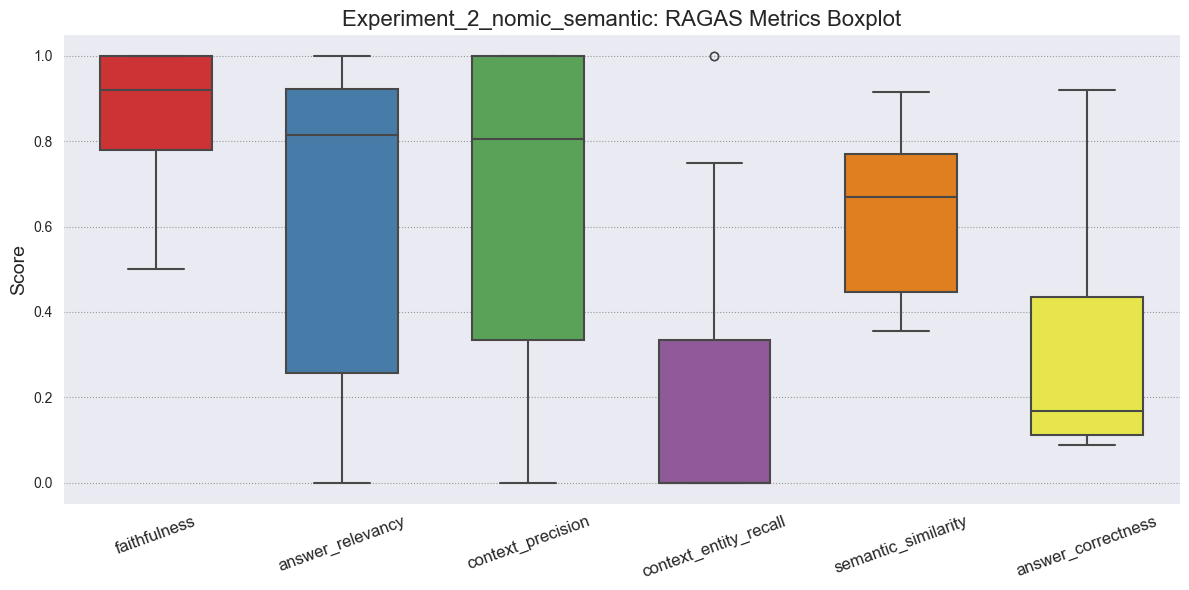

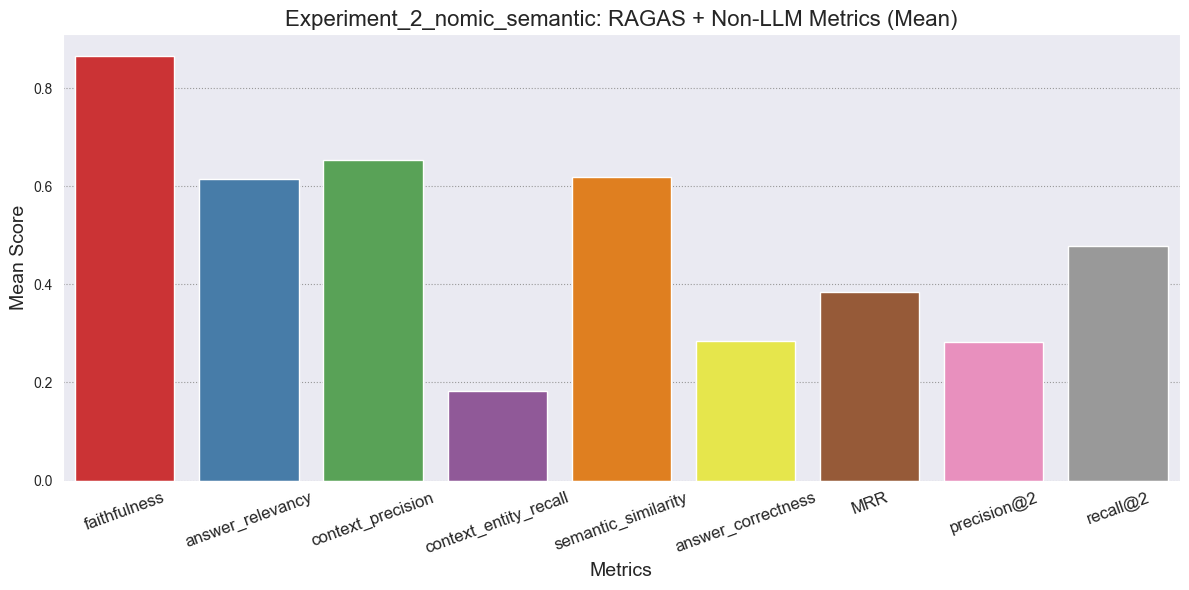

In [68]:
nomic_semantic_evaluation.plot_results_all(result_nomic_semantic)

In [69]:
combined_df = utils.add_to_combined("Experiment_2_nomic_semantic", result_nomic_semantic, combined_df)

**Insights from the Boxplot**

- Faithfulness: Shows a high median with minimal variability, indicating strong factual consistency in the responses generated.

- Answer Relevancy: This metric also displays a narrow interquartile range but has a few outliers, suggesting that while most answers are relevant, there are occasional deviations.

- Context Precision: Achieves high scores, indicating effective use of context in generating responses.

- Context Entity Recall: Exhibits lower performance with substantial variability, pointing to challenges in consistently capturing all relevant entities.

- Semantic Similarity: Shows considerable spread, suggesting inconsistency in the semantic alignment of responses with the expected answers.

- Answer Correctness: Also presents a wide range, with some outliers indicating lower performance, suggesting variability in how accurately the answers align with correct or expected responses.

**Insights from the Mean Scores Bar Chart**

- Faithfulness and Context Precision display the strongest performance, reaffirming the model’s ability to generate factually accurate and contextually precise responses.

- Answer Relevancy scores are also strong, yet the presence of outliers in the boxplot suggests that there are occasional lapses in relevancy.

- Context Entity Recall and Semantic Similarity are identified as weaker areas, with significant room for improvement in enhancing the consistency and accuracy of entity recall and semantic alignment.

- Answer Correctness shows moderate performance, aligning with the variability observed in the boxplot which points towards occasional inaccuracies.

- Non-LLM Metrics such as MRR, Precision@2, and Recall@2 indicate moderate to strong retrieval effectiveness, but improvements could boost the precision and comprehensiveness of relevant document retrieval.

**Overall**

The SemanticChunker strategy with the Nomic model excels in generating factually accurate and contextually precise responses. However, it struggles with consistency, particularly in entity recall and semantic similarity, which are crucial for generating fully accurate and contextually appropriate answers. The results suggest that while the semantic-based chunking helps in certain aspects, it may introduce complexities that affect other areas of performance, such as semantic alignment and overall answer correctness.

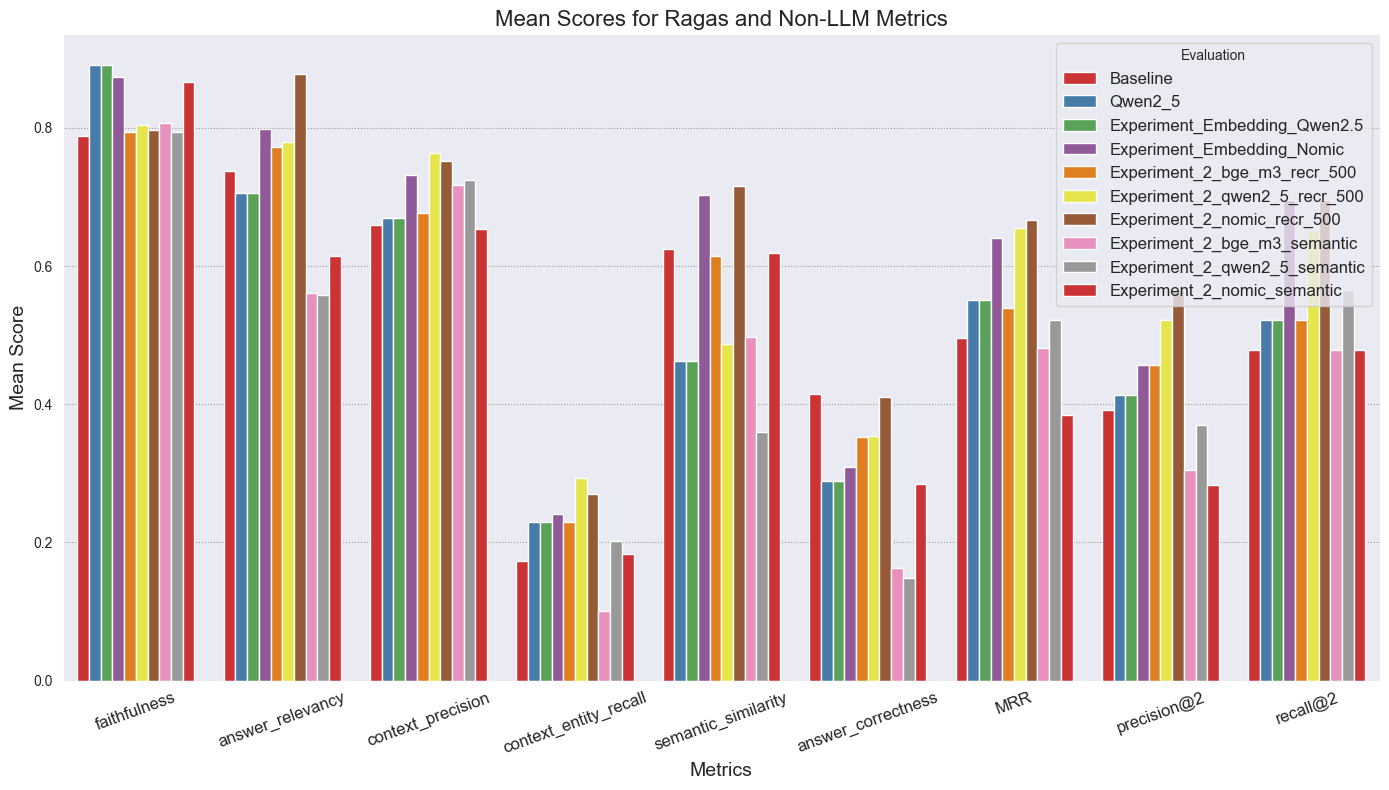

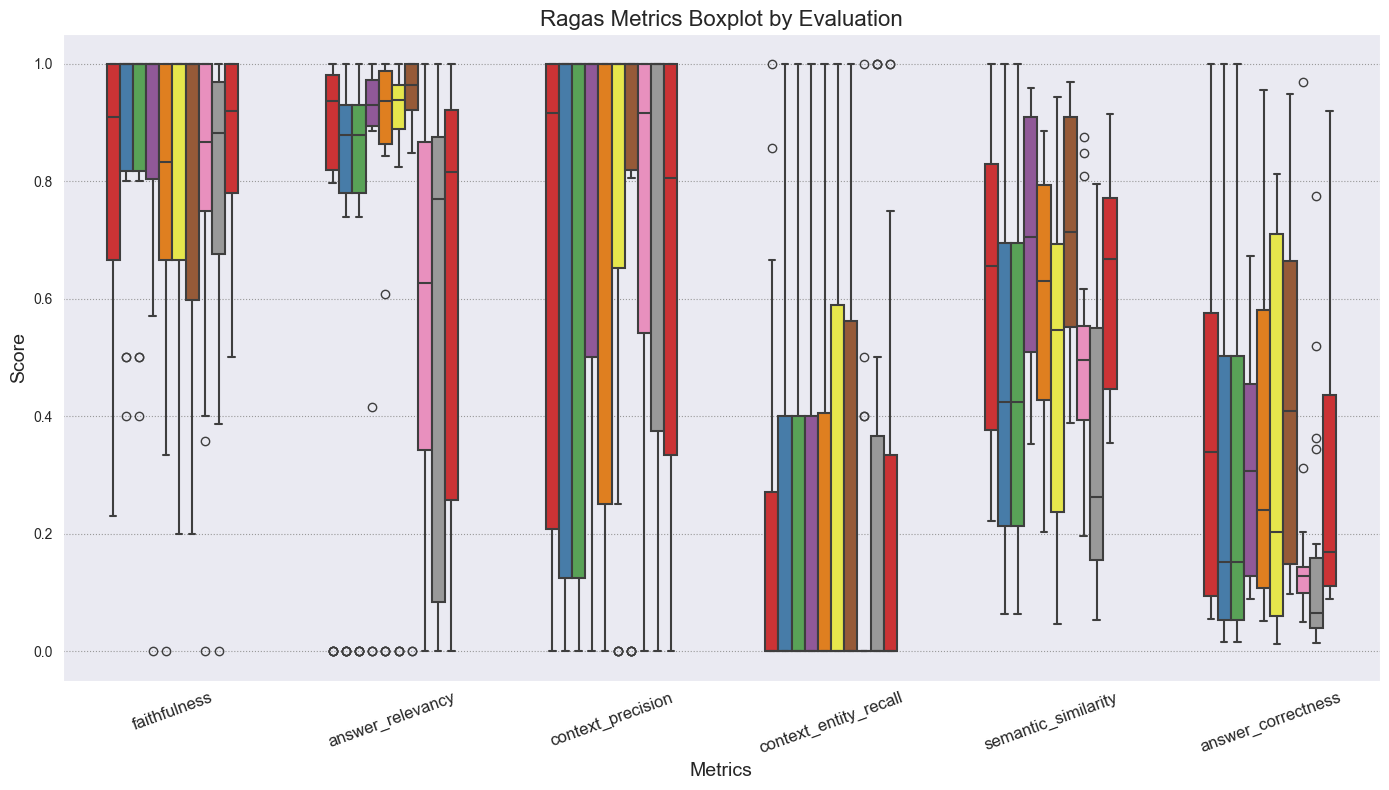

In [70]:
utils.plot_compare_result(combined_df)

**Comprehensive Insights**

- Faithfulness: The Qwen2.5 model with RecursiveCharacterTextSplitter (1000/0) showcases the highest mean scores, closely followed by the Nomic model using SemanticChunker. This indicates strong factual consistency across these setups.

- Answer Relevancy: The Nomic model with RecursiveCharacterTextSplitter (500/100) leads in answer relevancy, suggesting that smaller chunk sizes with overlaps may enhance the relevancy of responses by retaining more contextual information.

- Context Precision: High scores are observed in multiple setups: Nomic with RecursiveCharacterTextSplitter (1000/0), Qwen2.5 and Nomic with RecursiveCharacterTextSplitter (500/100), and the Qwen2.5 with SemanticChunker. These configurations effectively retrieve precise contextual information.

- Context Entity Recall: The Qwen2.5 and Nomic models with RecursiveCharacterTextSplitter (500/100) show the highest performance, indicating that a smaller chunk size with overlap aids in capturing relevant entities.

- Semantic Similarity: The Nomic model with RecursiveCharacterTextSplitter (500/100) excels, demonstrating its strength in maintaining semantic integrity across responses. The Qwen2.5 SemanticChunker lags significantly, suggesting it may struggle with semantic alignment.

- Answer Correctness: Strong performances are seen in the Nomic model with RecursiveCharacterTextSplitter (500/100) and the baseline settings, underscoring their ability to generate contextually and factually correct answers.

- MRR (Mean Reciprocal Rank): The Nomic model with smaller chunks (100/500) performs exceptionally, alongside the Qwen2.5 (500). This suggests that these configurations effectively prioritize relevant answers quickly.

- Precision@2 and Recall@2: The Nomic model with RecursiveCharacterTextSplitter (500) shows outstanding performance in both metrics, emphasizing its efficiency in identifying and ranking relevant content within the top results.

**Summary of Chunking Strategy and Model Effectiveness**

- RecursiveCharacterTextSplitter (500/100) generally performs well across multiple metrics, particularly in precision, entity recall, and relevancy, which highlights its utility in enhancing contextual understanding and response accuracy.

- SemanticChunker, while beneficial for certain metrics like faithfulness and precision, shows mixed results, especially in semantic similarity and correctness. This suggests that while it can effectively utilize semantic breaks for chunking, it might require additional optimizations to fully capitalize on its potential.

**Overall Performance**
Models and chunking strategies that balance precision, entity recall, and semantic alignment tend to deliver the most robust and accurate responses. The combination of Nomic and Qwen2.5 models with adaptive chunking strategies like RecursiveCharacterTextSplitter (500/100) appears to offer a promising approach for enhancing RAG system performance.

# <a id='toc13_'></a>[Experiment HyDE:](#toc0_)

The [HyDE](https://medium.aiplanet.com/advanced-rag-improving-retrieval-using-hypothetical-document-embeddings-hyde-1421a8ec075a) (Hypothetical Document Embedding) approach represents an innovative method within the Retrieval-Augmented Generation (RAG) framework, primarily focused on generating a hypothetical document based on the query and using this document to retrieve relevant information. This section outlines our experimental setup and evaluation of the HyDE model in the context of enhancing the RAG system’s performance, particularly in the Clean Technology Sector.

In [71]:
from langchain_core.prompts import ChatPromptTemplate

# Setup the prompt template
system_description = """You are an expert about the Clean Technology Sector.
                        Answer the user question as best you can. Answer as though you were writing a tutorial that addressed the user question."""

hyde_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_description),
        ("human", "{question}"),
    ]
)

# Define the model and output parser pipeline
gen_hypothetical_doc = (
    hyde_prompt
    | llm_model
    | StrOutputParser()
)

# Setup retrieval chain
hyde_retrieval_chain = (gen_hypothetical_doc | basic_retriever)

# Setup RAG chain
hyde_rag_chain = RunnableParallel(
    {
        "question": RunnablePassthrough(),  # Directly passes the question through
        "context": hyde_retrieval_chain    # Retrieves contextual information
    }
).assign(answer=basic_rag_chain)

# Invoke the system
result = hyde_rag_chain.invoke("What is the company's goal in reducing gas flaring?")

In [74]:
hyde_evaluation = RAGEvaluation(
    name="Experiment HyDE",
    rag_chain=hyde_rag_chain,
    llm_model=openai_llm_model,
    local_llm=llm_model.model,
    embeddings=bge_m3_embed
)

result_hyde = hyde_evaluation.evaluate(clean_file_path, eval_file_path, bge_m3_vectordb_baseline)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment HyDE_qwen2.5:3b-instruct_BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


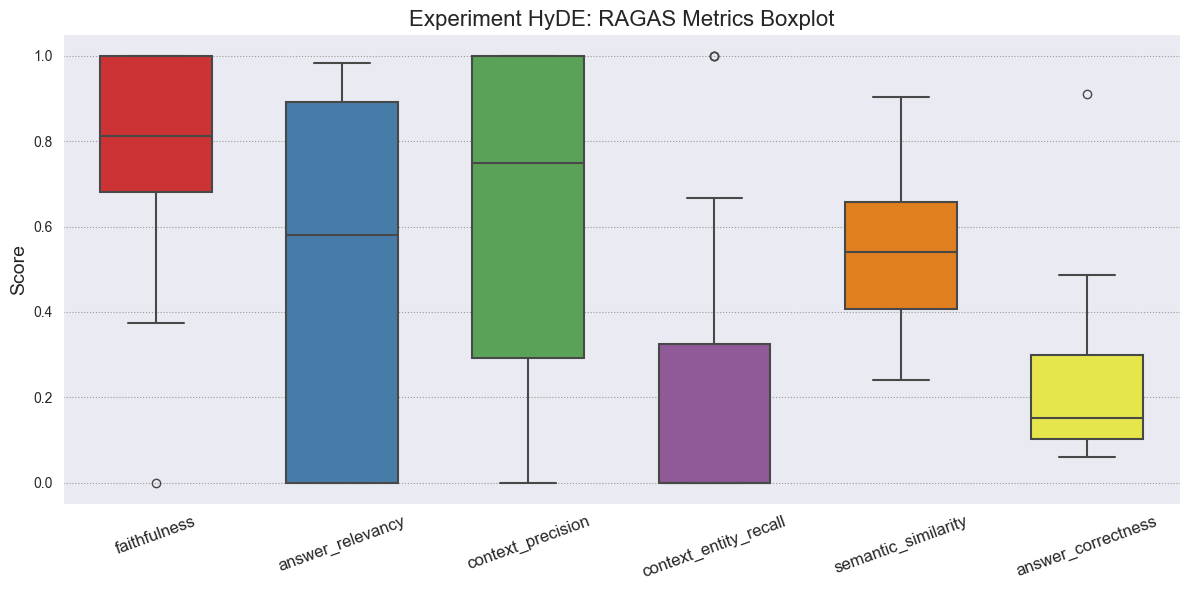

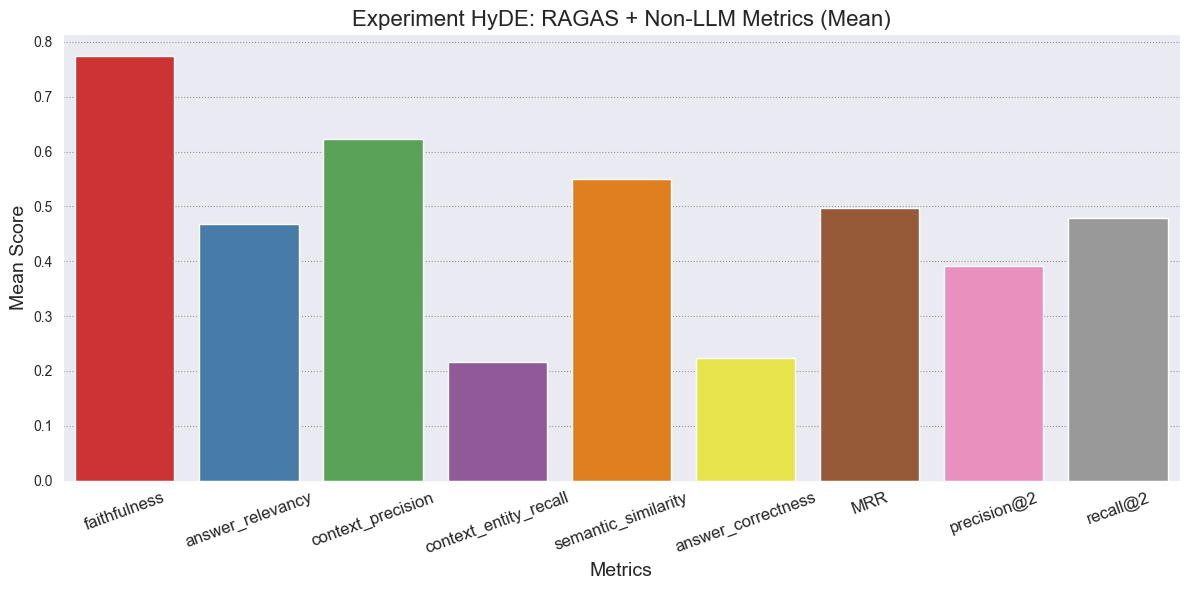

In [75]:
hyde_evaluation.plot_results_all(result_hyde)

In [76]:
combined_df = utils.add_to_combined("Experiment_HyDE", result_hyde, combined_df)

**Insights from the Boxplot**

- Faithfulness: Exhibits a high median and narrow interquartile range, indicating that most responses are factually consistent with the provided contexts.
  
- Answer Relevancy: The relevancy scores are moderately high but with some variability, suggesting occasional misalignments between the generated answers and the user queries.

- Context Precision: While the scores are generally good, the wide range indicates variability in how precisely the model uses the context to generate responses.

- Context Entity Recall: This metric shows significant variability, indicating inconsistencies in capturing all relevant entities from the context.

- Semantic Similarity: The wide range of scores suggests that the semantic alignment of responses varies considerably across different queries.

- Answer Correctness: Demonstrates the lowest performance with a broad spread, indicating that the accuracy of responses can vary significantly.

**Insights from the Mean Scores Bar Chart**

- Faithfulness achieves the highest mean score, underscoring the model’s ability to generate factually accurate responses.

- Context Precision and Answer Relevancy show strong performance, but the variability noted in the boxplot suggests that there are areas for improvement.

- Context Entity Recall and Semantic Similarity exhibit lower performance, highlighting challenges in consistently processing and semantically aligning the generated responses with the ideal answers.

- Answer Correctness displays the most room for improvement, with mean scores indicating that the responses often do not align well with what is factually or contextually correct.

**Overall Evaluation**

The HyDE model shows promise in maintaining high faithfulness and contextual precision, which are crucial for generating reliable and contextually relevant answers. However, the variability and lower performance in entity recall, semantic similarity, and answer correctness suggest that while the HyDE approach can effectively generate hypothetical answers, the translation of these answers into accurate, context-aligned responses needs refinement.


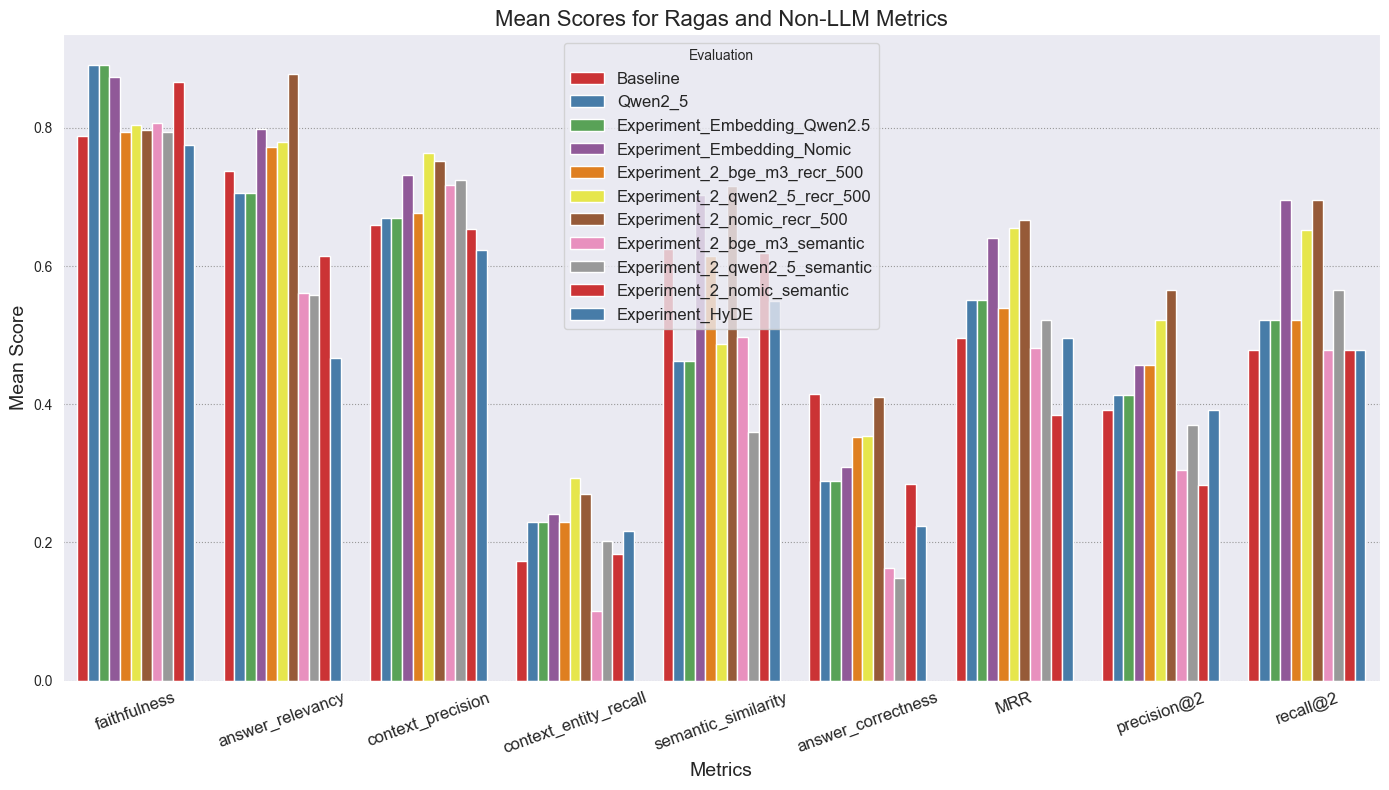

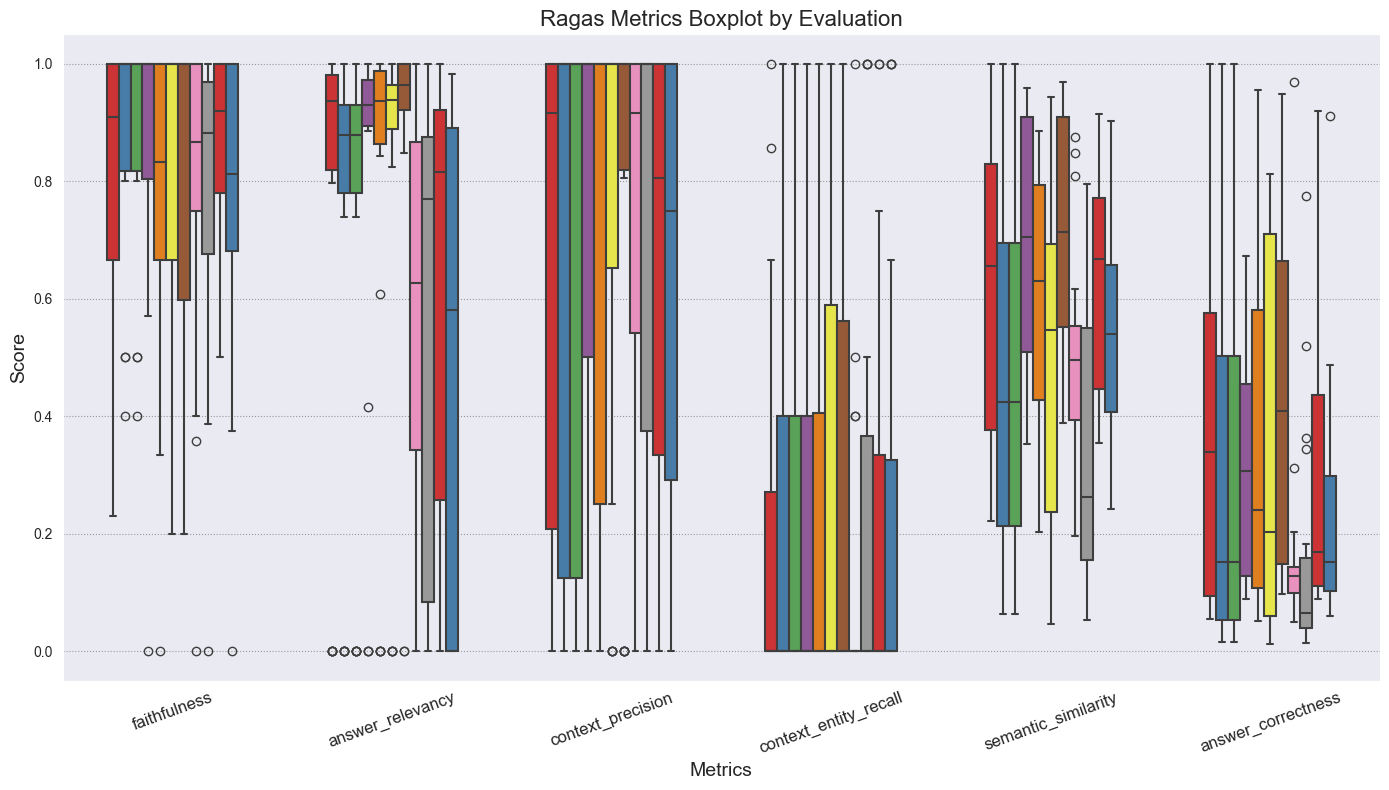

In [77]:
utils.plot_compare_result(combined_df)

**Comparative Analysis**

The HyDE experiment, which employs a hypothetical document embedding approach for retrieval, shows varied performance across different evaluation metrics when compared to other configurations. While it demonstrates decent context precision, it generally does not surpass the more traditional RAG setups or other specific embedding and chunking strategies in metrics like faithfulness, relevancy, and correctness. Despite its innovative approach, HyDE’s overall effectiveness is moderate, suggesting that further optimization or combining it with other proven methods could enhance its utility in complex query answering scenarios.

# <a id='toc14_'></a>[Personal Takeaways](#toc0_)

Though this work is to proof understanding and skills surrounding the task at hand, we would like to take a few minutes and each reflect in a few sentences the journey throught this mini-challenge.

### Arian

In this challenge, I had the incredible opportunity to learn so much about large language models, how a retrieval system works, and how the metrics are used to rank the relevant information of a query. Llm as a judge was also an amazing experience, seeing how the models judge each other. I found functionalities like Ollama or models from HuggingFace to be incredibly useful and easy to use. On top of all that, I also learned so much about Docker.

### Oliver

This project was an incredible opportunity for me to dive deep into the fascinating world of large language models, RAG systems, and how to use different models with HuggingFace, including Ollama. These tools are truly cutting-edge, combining advanced technology and data management to create smart responses. It was an amazing experience that has greatly increased my understanding and appreciation of how these powerful systems work.

### Christof

I've had a truly enriching experience taking part in this challenge! It's been an amazing opportunity to explore the cutting-edge RAG technologies that are changing the world. I've gained so much knowledge from new methodologies, scholarly papers and insights into infrastructure and computational frameworks. And it's been so inspiring to work with other like-minded individuals, sharing knowledge and skills, and fostering a real sense of camaraderie.

# <a id='toc15_'></a>[AI Tools - Improving Our Project with Assistance](#toc0_)

We've started using AI tools like ChatGPT and GitHub Copilot in our projects, and they've really helped us work better and solve problems faster. This document explains how we use these tools, what tasks they help with, and which ways of using them work best.

## <a id='toc15_1_'></a>[How AI Tools Help Us](#toc0_)

These AI tools make it easier for us to handle coding tasks and fix errors, freeing up time to focus on more important parts of our projects.

### <a id='toc15_2_'></a>[Using ChatGPT](#toc0_)

We use ChatGPT mainly for two things: fixing code errors and coming up with new ideas. When we run into a coding error, we paste the wrong code and the error message into ChatGPT, and it often gives us a solution right away. It's also great for brainstorming new ways to improve our projects, offering suggestions we might not think of on our own.

### <a id='toc15_3_'></a>[Using GitHub Copilot](#toc0_)

GitHub Copilot helps us write code faster. It's like having a coding assistant that suggests lines of code as we type, which is really helpful for straightforward tasks. For more complex problems, though, we still need to do a lot of the work ourselves.

### <a id='toc15_4_'></a>[What Works Best When Asking AI for Help](#toc0_)

Getting the best out of these AI tools depends on how we ask for help. For ChatGPT, being clear about what the error is and what part of the code isn't working is crucial. For new ideas, explaining exactly what we need helps the AI give us useful suggestions.

For GitHub Copilot, it helps to start by clearly writing out what we want the code to do. This makes the tool more likely to suggest the right kind of code.

### <a id='toc15_5_'></a>[Summary](#toc0_)

Using AI tools like ChatGPT and GitHub Copilot has made our projects run smoother and has sped up how quickly we can write code and fix problems. ChatGPT is excellent for quickly dealing with errors and for helping us think of new ideas. GitHub Copilot is great for speeding up our coding, especially for simpler tasks.